In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('Cython', cython.__version__)
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

Cython 3.0.0
TidalPy 0.5.0a5.dev30
CyRK 0.8.4


In [2]:
%load_ext cython

## Radial Solver Function

In [14]:
%%cython -a --force
# distutils: language = c++
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN, pow, floor, pi
from libcpp cimport bool as bool_cpp_t
import numpy as np
cimport numpy as np

np.import_array()


from cpython.mem cimport PyMem_Free

from CyRK.utils.utils cimport allocate_mem, reallocate_mem


cdef class RadialSolverSolution():

    cdef public str status
    cdef public bool_cpp_t success

    cdef double complex* full_solution_ptr
    cdef double complex[::1] full_solution_view

    cdef size_t num_ys
    cdef size_t num_slices
    cdef size_t total_size
    cdef size_t num_solvers

    cdef tuple solution_types

    def __init__(
            self,
            size_t num_ys,
            size_t num_slices,
            tuple solve_for,
            size_t num_solvers
            ):

        # loop indicies
        cdef size_t slice_i, y_i, sol_type_i

        # Initialize pointers
        self.full_solution_ptr = NULL

        # Initialize status
        self.status = 'RadialSolverSolution has not had its status set.'
        self.success = False
        
        # Store size information
        self.num_ys = num_ys
        self.num_slices = num_slices
        self.total_size = self.num_ys * self.num_slices

        # Have the radial solver take control of the full solution memory
        self.full_solution_ptr = <double complex*> allocate_mem(
            self.total_size * sizeof(double complex),
            'full_solution_ptr (RadialSolverSolution; init)'
            )
        if not (self.full_solution_ptr is NULL):
            self.full_solution_view = <double complex[:self.total_size]> self.full_solution_ptr
        
        # Set all values of the solution array to NANs. This ensures that if there is a problem with the solver then
        #  the solutions will be defined (but nan).
        for slice_i in range(self.num_slices):
            for y_i in range(self.num_ys):
                self.full_solution_ptr[slice_i * self.num_ys + y_i] = NAN

        # Store number of solution types
        self.num_solvers = num_solvers
        self.solution_types = solve_for

    @property
    def result(self):
        return np.ascontiguousarray(self.full_solution_view, dtype=np.complex128).reshape((self.num_ys, self.num_slices))
    
    def sett(self, double complex[::1] result):
        
        cdef size_t i
        for i in range(self.total_size):
            self.full_solution_ptr[i] = result[i]
    
    def __len__(self):
        """Return number of solution types."""
        return <Py_ssize_t>self.num_solvers
    
    def __getitem__(self, str solution_name):
        """Get a specific solution type array."""
        
        cdef size_t i
        cdef size_t requested_sol_num = 0
        cdef bool_cpp_t found = False
        cdef str sol_test_name
        for i in range(self.num_solvers):
            sol_test_name = self.solution_types[i]
            if sol_test_name == solution_name:
                requested_sol_num = i
                found = True
                break
        if not found:
            raise AttributeError('Unknown solution type requested. Must match name passed to radial_solver "solve_for" argument and be lower case.')
        
        # Slice the result and return only the requested solution type.
        return self.result[6 * (requested_sol_num): 6 * (requested_sol_num + 1)]

    def __dealloc__(self):
        # The RadialSolverSolution class has full control of the solution so it is responsible for releasing its memory.
        if not (self.full_solution_ptr is NULL):
            PyMem_Free(self.full_solution_ptr)

Content of stdout:
_cython_magic_ffe6606dee591263575f68842745e204bf646455.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_ffe6606dee591263575f68842745e204bf646455.cpp(26283): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_ffe6606dee591263575f68842745e204bf646455.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_ffe6606dee591263575f68842745e204bf646455.cp311-win_amd64.exp
Generating code
Finished generating code

In [15]:
all_results = np.asarray((
    (0, 1, 2, 3),
    (10, 11, 12, 13),
    (20, 21, 22, 23),
    (30, 31, 32, 33),
    (40, 41, 42, 43),
    (50, 51, 52, 53),
    (60, 61, 62, 63),
    (70, 71, 72, 73),
    (80, 81, 82, 83),
    (90, 91, 92, 93),
    (100, 101, 102, 103),
    (110, 111, 112, 113)), dtype=np.complex128
)

num_ys = 12
num_slices = 4
solve_for = ('tidal', 'free')
num_solvers = 2

RS = RadialSolverSolution(num_ys, num_slices, solve_for, num_solvers)

RS.sett(all_results.flatten())

In [18]:
RS.result

array([[  0.+0.j,   1.+0.j,   2.+0.j,   3.+0.j],
       [ 10.+0.j,  11.+0.j,  12.+0.j,  13.+0.j],
       [ 20.+0.j,  21.+0.j,  22.+0.j,  23.+0.j],
       [ 30.+0.j,  31.+0.j,  32.+0.j,  33.+0.j],
       [ 40.+0.j,  41.+0.j,  42.+0.j,  43.+0.j],
       [ 50.+0.j,  51.+0.j,  52.+0.j,  53.+0.j],
       [ 60.+0.j,  61.+0.j,  62.+0.j,  63.+0.j],
       [ 70.+0.j,  71.+0.j,  72.+0.j,  73.+0.j],
       [ 80.+0.j,  81.+0.j,  82.+0.j,  83.+0.j],
       [ 90.+0.j,  91.+0.j,  92.+0.j,  93.+0.j],
       [100.+0.j, 101.+0.j, 102.+0.j, 103.+0.j],
       [110.+0.j, 111.+0.j, 112.+0.j, 113.+0.j]])

In [21]:
RS['hj']

AttributeError: Unknown solution type requested. Must match name passed to radial_solver "solve_for" argument and be lower case.

In [3]:
%%cython --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
from libcpp cimport bool as bool_cpp_t


from scipy.linalg.cython_lapack cimport zgesv

from scipy.constants import G as G_


# TODO: ReDimen Radial
from TidalPy.radial_solver.nondimensional import re_dimensionalize_radial_func

# Import cythonized functions
from TidalPy.utilities.dimensions.nondimensional cimport cf_non_dimensionalize_physicals

from TidalPy.RadialSolver.starting.driver cimport cf_find_starting_conditions
from TidalPy.RadialSolver.solutions cimport cf_find_num_solutions
from TidalPy.RadialSolver.interfaces.interfaces cimport cf_solve_upper_y_at_interface


# Setup globals
cdef double G
G = G_


from CyRK.array.interp cimport interpj_ptr, interp_ptr, interp_complex_ptr

from libc.stdio cimport printf


# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN, pow, floor, pi

from cpython.mem cimport PyMem_Free


import numpy as np
cimport numpy as np

np.import_array()

from CyRK.utils.utils cimport allocate_mem, reallocate_mem
from CyRK.rk.rk cimport find_rk_properties
from CyRK.cy.common cimport interpolate, SAFETY, MIN_FACTOR, MAX_FACTOR, MAX_STEP, INF, EPS_100, \
    find_expected_size, find_max_num_steps

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)


cdef class CySolver:
    
    # Class attributes
    # -- Solution variables
    cdef double* solution_y_ptr
    cdef double* solution_t_ptr
    cdef double* solution_extra_ptr
    cdef double[::1] solution_t_view
    cdef double[::1] solution_y_view
    cdef double[::1] solution_extra_view

    # -- Dependent (y0) variable information
    cdef size_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef double* y0_ptr

    # -- Time information
    cdef double t_start, t_end, t_delta, t_delta_abs, direction_inf
    cdef bool_cpp_t direction_flag

    # -- Optional args info
    cdef size_t num_args
    cdef double* args_ptr
    cdef bool_cpp_t use_args

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef size_t num_extra

    # -- Integration information
    cdef readonly char status
    cdef readonly str message
    cdef public bool_cpp_t success
    cdef double* tol_ptrs
    cdef double* rtols_ptr
    cdef double* atols_ptr
    cdef double first_step, max_step
    cdef bool_cpp_t user_provided_max_num_steps
    cdef size_t max_num_steps
    cdef size_t expected_size, current_size, num_concats
    cdef bool_cpp_t recalc_first_step
    cdef bool_cpp_t force_fail

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef size_t len_t_eval
    cdef double* t_eval_ptr

    # -- RK method information
    cdef size_t rk_method, rk_order, error_order, rk_n_stages, rk_n_stages_plus1
    cdef double error_expo
    cdef size_t len_C, len_Arows, len_Acols
    cdef double* A_ptr
    cdef double* B_ptr
    cdef double* C_ptr
    cdef double* E_ptr
    cdef double* E3_ptr
    cdef double* E5_ptr
    # K is not constant. It is a temp storage variable used in RK calculations
    cdef double* K_ptr

    # -- Live variables
    cdef double t_now, t_old, step_size
    cdef size_t len_t, len_t_touse
    cdef double* temporary_y_ptrs
    cdef double* y_ptr
    cdef double* y_old_ptr
    cdef double* dy_ptr
    cdef double* dy_old_ptr
    cdef double* extra_output_ptrs
    cdef double* extra_output_init_ptr
    cdef double* extra_output_ptr

    # -- Pointers used during solve method
    cdef double* _solve_time_domain_array_ptr
    cdef double* _solve_y_results_array_ptr
    cdef double* _solve_extra_array_ptr

    # -- Pointers used during interpolation
    cdef double* _interpolate_solution_t_ptr
    cdef double* _interpolate_solution_y_ptr
    cdef double* _interpolate_solution_extra_ptr

    def __init__(self,
            (double, double) t_span,
            const double[::1] y0,
            tuple args = None,
            double rtol = 1.e-3,
            double atol = 1.e-6,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            size_t max_num_steps = 0,
            const double[::1] t_eval = None,
            bool_cpp_t capture_extra = False,
            size_t num_extra = 0,
            bool_cpp_t interpolate_extra = False,
            size_t expected_size = 0,
            size_t max_ram_MB = 2000,
            bool_cpp_t call_first_reset = True,
            bool_cpp_t auto_solve = True,
            bool_cpp_t force_fail = False):

        printf('\tCySolver - INIT\n')
        # Initialize all class pointers to null
        self.tol_ptrs = NULL
        self.rtols_ptr = NULL
        self.atols_ptr = NULL
        self.solution_y_ptr = NULL
        self.solution_t_ptr = NULL
        self.solution_extra_ptr = NULL
        self.y0_ptr = NULL
        self.args_ptr = NULL
        self.t_eval_ptr = NULL
        self.A_ptr = NULL
        self.B_ptr = NULL
        self.C_ptr = NULL
        self.E_ptr = NULL
        self.E3_ptr = NULL
        self.E5_ptr = NULL
        self.K_ptr = NULL
        self.temporary_y_ptrs = NULL
        self.y_ptr = NULL
        self.y_old_ptr = NULL
        self.dy_ptr = NULL
        self.dy_old_ptr = NULL
        self.extra_output_ptrs = NULL
        self.extra_output_init_ptr = NULL
        self.extra_output_ptr = NULL
        self._solve_time_domain_array_ptr = NULL
        self._solve_y_results_array_ptr = NULL
        self._solve_extra_array_ptr = NULL
        self._interpolate_solution_t_ptr = NULL
        self._interpolate_solution_y_ptr = NULL 
        self._interpolate_solution_extra_ptr = NULL

        # Loop variables
        cdef size_t i

        # Set integration information
        self.status  = -4  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False
        self.recalc_first_step = False
        self.force_fail = force_fail

        # Store y0 values and determine y-size information
        self.y_size = y0.size
        self.y_size_dbl = <double> self.y_size
        printf('\tCySolver - y0-ptr - allocate\n')
        self.y_size_sqrt = sqrt(self.y_size_dbl)
        self.y0_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'y0_ptr (init)')
        printf('\tCySolver - y0-ptr - allocate done: %p\n', self.y0_ptr)
        printf('\tCySolver - y0-ptr - populate\n')
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]
        printf('\tCySolver - y0-ptr - populate - done\n')

        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        if self.t_delta >= 0.:
            # Integration is moving forward in time.
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            # Integration is moving backwards in time.
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # Determine integration tolerances
        printf('\tCySolver - tol-ptrs - allocate\n')
        self.tol_ptrs  = <double *> allocate_mem(2 * self.y_size * sizeof(double), 'tol_ptrs (init)')
        printf('\tCySolver - tol-ptrs - allocate done: %p\n', self.tol_ptrs, self.rtols_ptr, self.atols_ptr)
        self.rtols_ptr = &self.tol_ptrs[0]
        self.atols_ptr = &self.tol_ptrs[self.y_size]
        printf('\tCySolver - tol-ptrs - suballocates done: %p, %p\n', self.rtols_ptr, self.atols_ptr)
        cdef double rtol_tmp, rtol_min
        rtol_min = INF
        
        printf('\tCySolver - tol-ptrs - populate\n')
        if rtols is not None:
            # User provided an arrayed version of rtol.
            if len(rtols) != self.y_size:
                raise AttributeError('rtol array must be the same size as y0.')
            for i in range(self.y_size):
                rtol_tmp = rtols[i]
                # Check that the tolerances are not too small.
                if rtol_tmp < EPS_100:
                    rtol_tmp = EPS_100
                rtol_min = fmin(rtol_min, rtol_tmp)
                self.rtols_ptr[i] = rtol_tmp
        else:
            # No array provided. Use the same rtol for all ys.
            # Check that the tolerances are not too small.
            if rtol < EPS_100:
                rtol = EPS_100
            rtol_min = rtol
            for i in range(self.y_size):
                self.rtols_ptr[i] = rtol

        if atols is not None:
            # User provided an arrayed version of atol.
            if len(atols) != self.y_size:
                raise AttributeError('atol array must be the same size as y0.')
            for i in range(self.y_size):
                self.atols_ptr[i] = atols[i]
        else:
            # No array provided. Use the same atol for all ys.
            for i in range(self.y_size):
                self.atols_ptr[i] = atol
        printf('\tCySolver - tol-ptrs - populate done\n')
        
        # Determine extra outputs
        self.capture_extra = capture_extra
        # To avoid memory access violations we need to set the extra output arrays no matter if they are used.
        # If not used, just set them to size zero.
        if self.capture_extra:
            if num_extra <= 0:
                self.status = -8
                raise AttributeError('Capture extra set to True, but number of extra set to 0 (or negative).')
            self.num_extra = num_extra
        else:
            # Even though we are not capturing extra, we still want num_extra to be equal to 1 so that nan arrays
            # are properly initialized
            self.num_extra = 1

        # Expected size of output arrays.
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            self.expected_size = find_expected_size(
                self.y_size,
                num_extra,
                self.t_delta_abs,
                rtol_min,
                capture_extra,
                False)
        else:
            self.expected_size = expected_size
        # Set the current size to the expected size.
        # `expected_size` should never change but current might grow if expected size is not large enough.
        self.current_size = self.expected_size

        # Determine max number of steps
        find_max_num_steps(
            self.y_size,
            self.num_extra,
            max_num_steps,
            max_ram_MB,
            capture_extra,
            False,
            &self.user_provided_max_num_steps,
            &self.max_num_steps)

        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)
        printf('\tCySolver - arg-ptr - allocate\n')
        self.args_ptr = <double *> allocate_mem(self.num_args * sizeof(double), 'args_ptr (init)')
        printf('\tCySolver - arg-ptr - allocate done: %p\n', self.args_ptr)
        printf('\tCySolver - arg-ptr - populate\n')
        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN
        printf('\tCySolver - arg-ptr - populate done\n')

        # Initialize live variable arrays
        printf('\tCySolver - y-tmp-ptrs - allocate\n')
        self.temporary_y_ptrs = <double *> allocate_mem(4 * self.y_size * sizeof(double), 'temporary_y_ptrs (init)')
        printf('\tCySolver - y-tmp-ptrs - allocate done: %p\n', self.temporary_y_ptrs)
        self.y_ptr      = &self.temporary_y_ptrs[0 * self.y_size]
        self.y_old_ptr  = &self.temporary_y_ptrs[1 * self.y_size]
        self.dy_ptr     = &self.temporary_y_ptrs[2 * self.y_size]
        self.dy_old_ptr = &self.temporary_y_ptrs[3 * self.y_size]
        printf('\tCySolver - y-tmp-ptrs - sub-allocates done: %p, %p, %p, %p\n', self.y_ptr, self.y_old_ptr, self.dy_ptr, self.dy_old_ptr)
        
        printf('\tCySolver - exta-ptrs - allocate\n')
        self.extra_output_ptrs = <double *> allocate_mem(2 * self.num_extra * sizeof(double), 'extra_output_ptrs (init)')
        printf('\tCySolver - exta-ptrs - allocate done: %p\n', self.extra_output_ptrs)

        self.extra_output_init_ptr = &self.extra_output_ptrs[0 * self.num_extra]
        self.extra_output_ptr      = &self.extra_output_ptrs[1 * self.num_extra]
        printf('\tCySolver - exta-ptrs - suballocates done: %p, %p\n', self.extra_output_init_ptr, self.extra_output_ptr)
       
        for i in range(self.num_extra):
            self.extra_output_init_ptr[i] = NAN
            self.extra_output_ptr[i]      = NAN
        
        printf('\tCySolver - y-tmp-ptrs - DONE\n')

        # Initialize storage variables
        printf('\tCySolver - solution t ptr - allocate\n')
        self.solution_t_ptr = <double *> allocate_mem(sizeof(double), 'solution_t_ptr (init)')
        printf('\tCySolver - solution t ptr - allocate done: %p\n', self.solution_t_ptr)
        self.solution_t_ptr[0] = NAN

        printf('\tCySolver - solution y ptr - allocate\n')
        self.solution_y_ptr = <double *> allocate_mem(self.y_size * sizeof(double), 'solution_y_ptr (init)')
        printf('\tCySolver - solution y ptr - allocate done: %p\n', self.solution_y_ptr)
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN
        
        printf('\tCySolver - solution extra ptr - allocate\n')
        self.solution_extra_ptr = <double *> allocate_mem(self.num_extra * sizeof(double), 'solution_extra_ptr (init)')
        printf('\tCySolver - solution extra ptr - allocate done: %p\n', self.solution_extra_ptr)
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        printf('\tCySolver - solution - memory views\n')
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr
        printf('\tCySolver - solution memory views - DONE\n')

        # Determine interpolation information
        printf('\tCySolver - teval\n')
        if t_eval is None:
            printf('\t\tCySolver - teval - NOT PROVIDED\n')
            self.run_interpolation = False
            self.interpolate_extra = False
            # Even though we are not using t_eval, set its size equal to one so that nan arrays can be built
            self.len_t_eval = 1
        else:
            printf('\t\tCySolver - teval - PROVIDED\n')
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)
        
        printf('\t\tCySolver - teval - ALLOCATE, %d\n', self.len_t_eval)
        self.t_eval_ptr = <double *> allocate_mem(self.len_t_eval * sizeof(double), 't_eval_ptr (init)')
        printf('\t\tCySolver - teval - ALLOCATE - DONE: %p', self.t_eval_ptr)
        printf('\t\tCySolver - teval - POPULATE, %d', self.run_interpolation)
        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]
            else:
                self.t_eval_ptr[i] = NAN
        printf('\tCySolver - teval - DONE\n')

        # Initialize RK arrays
        printf('\tCySolver - RK method\n')
        self.rk_method = rk_method
        find_rk_properties(
            self.rk_method,
            &self.rk_order,
            &self.error_order,
            &self.rk_n_stages,
            &self.len_Arows,
            &self.len_Acols,
            &self.A_ptr,
            &self.B_ptr,
            &self.C_ptr,
            &self.E_ptr,
            &self.E3_ptr,
            &self.E5_ptr
            )

        if self.rk_order == 0:
            raise AttributeError('Unknown or not-yet-implemented RK method requested.')
        
        self.len_C             = self.rk_n_stages
        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)
        # Initialize other RK-related Arrays
        self.K_ptr = <double *> allocate_mem(self.rk_n_stages_plus1 * self.y_size * sizeof(double), 'K_ptr (init)')
        printf('\tCySolver - rk method - DONE\n')
        # Store user provided step information
        self.first_step = first_step
        self.max_step   = max_step

        # Parameters are initialized but may not be set to correct values.
        # Call reset state to ensure everything is ready.
        if call_first_reset or auto_solve:
            self.reset_state()

        # Run solver if requested
        if auto_solve:
            # We know for a fact that this is the first time solve will be called and we just reset the Sovler's state
            # So we can safely tell the solve method not to reset.
            self._solve(NULL, reset=False)

    cpdef void reset_state(self):
        """ Resets the class' state variables so that integration can be rerun. """
        cdef size_t i, j
        cdef double temp_double
        printf('\tCySolver - reset_state - called \n')

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_now = self.t_start
        # Track number of steps.
        # Initial conditions were provided so the number of steps is already 1
        self.len_t = 1

        # It is important K be initialized with 0s
        printf('\tCySolver - reset_state - update ys and K\n')
        for i in range(self.rk_n_stages_plus1):
            for j in range(self.y_size):
                self.K_ptr[i * self.y_size + j] = 0.

                # While we have this loop; set y back to initial conditions
                if i == 0:
                    temp_double       = self.y0_ptr[j]
                    self.y_ptr[j]     = temp_double
                    self.y_old_ptr[j] = temp_double

        # Update any constant parameters that the user has set
        printf('\tCySolver - reset_state - update contants\n')
        self.update_constants()

        # Make initial call to diffeq()
        printf('\tCySolver - reset_state - diffeq\n')
        self.diffeq()

        # Store first dydt
        printf('\tCySolver - reset_state - update dydt\n')
        for i in range(self.y_size):
            self.dy_old_ptr[i] = self.dy_ptr[i]

        # Store extra outputs for the first time step
        if self.capture_extra:
            for i in range(self.num_extra):
                self.extra_output_init_ptr[i] = self.extra_output_ptr[i]

        # Determine first step's size
        if self.first_step == 0. or self.recalc_first_step:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.current_size = self.expected_size
        self.num_concats = 1

        # Reset storage variables to clear any old solutions and to avoid access violations if solve() is not called.
        printf('\tCySolver - reset_state - update solution\n')
        self.solution_t_ptr[0] = NAN
        for i in range(self.y_size):
            self.solution_y_ptr[i] = NAN
        for i in range(self.num_extra):
            self.solution_extra_ptr[i] = NAN

        # Have solution memoryviews point to these addresses
        self.solution_t_view     = <double[:1]> self.solution_t_ptr
        self.solution_y_view     = <double[:self.y_size]> self.solution_y_ptr
        self.solution_extra_view = <double[:self.num_extra]> self.solution_extra_ptr

        # Other integration flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."

    cdef double calc_first_step(self) :
        """
        Select an initial step size based on the differential equation.
        .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
               Equations I: Nonstiff Problems", Sec. II.4.
        """

        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale
        cdef double y_old_tmp

        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                y_old_tmp = self.y_old_ptr[i]

                scale = self.atols_ptr[i] + fabs(y_old_tmp) * self.rtols_ptr[i]

                d0_abs = fabs(y_old_tmp / scale)
                d1_abs = fabs(self.dy_old_ptr[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            if self.direction_flag:
                h0_direction = h0
            else:
                h0_direction = -h0

            self.t_now = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_ptr[i] = self.y_old_ptr[i] + h0_direction * self.dy_old_ptr[i]

            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):

                scale = self.atols_ptr[i] + fabs(self.y_old_ptr[i]) * self.rtols_ptr[i]
                d2_abs = fabs( (self.dy_ptr[i] - self.dy_old_ptr[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = fmax(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / fmax(d1, d2))**self.error_expo

            step_size = fmax(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            fmin(100. * h0, h1))

        return step_size

    cdef void rk_step(self) :
        """ Performs a Runge-Kutta step calculation including local error determination. """

        # Initialize step variables
        cdef size_t s, i, j
        cdef double min_step, step, step_factor, time_tmp, t_delta_check
        cdef double scale, temp_double
        cdef double error_norm3, error_norm5, error_norm, error_dot_1, error_dot_2, error_denom, error_pow
        cdef bool_cpp_t step_accepted, step_rejected, step_error

        # Run RK integration step
        # Determine step size based on previous loop
        # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
        min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
        # Look for over/undershoots in previous step size
        if self.step_size > self.max_step:
            self.step_size = self.max_step
        elif self.step_size < min_step:
            self.step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error    = False

        # Optimization variables
        cdef double A_at_10
        # Define a very specific A (Row 1; Col 0) now since it is called consistently and does not change.
        A_at_10 = self.A_ptr[1 * self.len_Acols + 0]

        # # Step Loop
        while not step_accepted:
            if self.step_size < min_step:
                step_error  = True
                self.status = -1
                break

            # Move time forward for this particular step size
            if self.direction_flag:
                step          = self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_now - self.t_end
            else:
                step          = -self.step_size
                self.t_now    = self.t_old + step
                t_delta_check = self.t_end - self.t_now

            # Check that we are not at the end of integration with that move
            if t_delta_check > 0.:
                self.t_now = self.t_end

                # If we are, correct the step so that it just hits the end of integration.
                step = self.t_now - self.t_old
                if self.direction_flag:
                    self.step_size = step
                else:
                    self.step_size = -step

            # # Calculate derivative using RK method

            # t_now must be updated for each loop of s in order to make the diffeq calls.
            # But we need to return to its original value later on. Store in temp variable.
            time_tmp = self.t_now

            for s in range(1, self.len_C):
                # Update t_now so it can be used in the diffeq call.
                self.t_now = self.t_old + self.C_ptr[s] * step

                # Dot Product (K, a) * step
                if s == 1:
                    for i in range(self.y_size):
                        # Set the first column of K
                        temp_double = self.dy_old_ptr[i]
                        # K[0, :] == first part of the array
                        self.K_ptr[i] = temp_double

                        # Calculate y_new for s==1
                        self.y_ptr[i] = self.y_old_ptr[i] + (temp_double * A_at_10 * step)
                else:
                    for j in range(s):
                        temp_double = self.A_ptr[s * self.len_Acols + j] * step
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_ptr[i] = self.y_old_ptr[i]

                            self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

                # Call diffeq to update K with the new dydt
                self.diffeq()

                for i in range(self.y_size):
                    self.K_ptr[s * self.y_size + i] = self.dy_ptr[i]

            # Restore t_now to its previous value.
            self.t_now = time_tmp

            # Dot Product (K, B) * step
            for j in range(self.rk_n_stages):
                temp_double = self.B_ptr[j] * step
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(self.y_size):
                    if j == 0:
                        # Initialize
                        self.y_ptr[i] = self.y_old_ptr[i]

                    self.y_ptr[i] += self.K_ptr[j * self.y_size + i] * temp_double

            # Find final dydt for this timestep
            self.diffeq()

            # Check how well this step performed by calculating its error
            if self.rk_method == 2:
                # Calculate Error for DOP853
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                error_norm3 = 0.
                error_norm5 = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    error_dot_2 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        temp_double = self.K_ptr[j * self.y_size + i]
                        error_dot_1 += temp_double * self.E3_ptr[j]
                        error_dot_2 += temp_double * self.E5_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm3_abs = fabs(error_dot_1)
                    # error_norm5_abs = fabs(error_dot_2)
                    error_dot_1 /= scale
                    error_dot_2 /= scale

                    error_norm3 += (error_dot_1 * error_dot_1)
                    error_norm5 += (error_dot_2 * error_dot_2)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                # Dot Product (K, E) * step / scale
                error_norm = 0.
                for i in range(self.y_size):
                    # Find scale of y for error calculations
                    scale = (self.atols_ptr[i] +
                             max(fabs(self.y_old_ptr[i]), fabs(self.y_ptr[i])) * self.rtols_ptr[i])

                    # Set last array of K equal to dydt
                    self.K_ptr[self.rk_n_stages * self.y_size + i] = self.dy_ptr[i]
                    # Initialize
                    error_dot_1 = 0.
                    for j in range(self.rk_n_stages_plus1):

                        error_dot_1 += self.K_ptr[j * self.y_size + i] * self.E_ptr[j]

                    # We need the absolute value but since we are taking the square, it is guaranteed to be positive.
                    # TODO: This will need to change if CySolver ever accepts complex numbers
                    # error_norm_abs = fabs(error_dot_1)
                    error_dot_1 *= (step / scale)

                    error_norm += (error_dot_1 * error_dot_1)
                error_norm = sqrt(error_norm) / self.y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    error_pow = pow(error_norm, -self.error_expo)
                    step_factor = fmin(MAX_FACTOR, SAFETY * error_pow)

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = fmin(step_factor, 1.)

                self.step_size = self.step_size * step_factor
                step_accepted = True
            else:
                error_pow = pow(error_norm, -self.error_expo)
                self.step_size = self.step_size * fmax(MIN_FACTOR, SAFETY * error_pow)
                step_rejected = True

        if step_error:
            # Issue with step convergence
            self.status = -1
        elif not step_accepted:
            # Issue with step convergence
            self.status = -7

        # End of step loop. Update the 'old' variables
        self.t_old = self.t_now
        for i in range(self.y_size):
            self.y_old_ptr[i]  = self.y_ptr[i]
            self.dy_old_ptr[i] = self.dy_ptr[i]

    cpdef void solve(
            self,
            bool_cpp_t reset = True
            ):
        """
        Public wrapper to the private solve method which calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        self._solve(NULL, reset=reset)

    cdef void _solve(
            self,
            double complex*** ptr_tracker,
            bool_cpp_t reset = True
            ):
        """
        Calculates the integral of the user-provided system of ODEs.
        
        Parameters
        ----------
        reset : bool_cpp_t, default=True
            If True, `reset_state()` will be called before integration starts.
        """
        printf('\tCySolver - SOLVE\n')
        
        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef size_t i
        
        printf('\t\tCySolver - Solve - POINTER TRACKER 1: %p\n', ptr_tracker[0][0])

        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
        printf('\tCySolver - SOLVE - Build pointers\n')
        if self._solve_time_domain_array_ptr is NULL:
            self._solve_time_domain_array_ptr = <double *> allocate_mem(
                self.current_size * sizeof(double),
                '_solve_time_domain_array_ptr (_solve)')
        else:
            self._solve_time_domain_array_ptr = <double *> reallocate_mem(
                self._solve_time_domain_array_ptr,
                self.current_size * sizeof(double),
                '_solve_time_domain_array_ptr (_solve)')

        if self._solve_y_results_array_ptr is NULL:
            self._solve_y_results_array_ptr = <double *> allocate_mem(
                self.y_size * self.current_size * sizeof(double),
                '_solve_y_results_array_ptr (_solve)')
        else:
            self._solve_y_results_array_ptr = <double *> reallocate_mem(
                self._solve_y_results_array_ptr,
                self.y_size * self.current_size * sizeof(double),
                '_solve_y_results_array_ptr (_solve)')
        
        if self.capture_extra:
            if self._solve_extra_array_ptr is NULL:
                self._solve_extra_array_ptr = <double *> allocate_mem(
                    self.num_extra * self.current_size * sizeof(double),
                    '_solve_extra_array_ptr (_solve)')
            else:
                self._solve_extra_array_ptr = <double *> reallocate_mem(
                    self._solve_extra_array_ptr,
                    self.num_extra * self.current_size * sizeof(double),
                    '_solve_extra_array_ptr (_solve)')
        printf('\tCySolver - SOLVE - Build pointers - DONE\n')

        # Load initial conditions into storage arrays
        printf('\tCySolver - SOLVE - populate pointers\n')
        self._solve_time_domain_array_ptr[0] = self.t_start
        for i in range(self.y_size):
            self._solve_y_results_array_ptr[i] = self.y0_ptr[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                self._solve_extra_array_ptr[i] = self.extra_output_init_ptr[i]
        printf('\tCySolver - SOLVE - populate pointers - DONE\n')

        # # Main integration loop
        self.status = 0

        if self.y_size == 0:
            self.status = -6

        printf('\t\tCySolver - Solve - POINTER TRACKER Pre-Solve: %p\n', ptr_tracker[0][0])
        while self.status == 0:

            # Check that integration is not complete.
            if self.t_now == self.t_end:
                self.t_old = self.t_end
                self.status = 1
                break

            # Check that maximum number of steps has not been exceeded.
            if self.len_t > self.max_num_steps:
                if self.user_provided_max_num_steps:
                    self.status = -2
                else:
                    self.status = -3
                break

            # # Perform RK Step
            self.rk_step()

            # Check if an error occurred during step calculations before storing data.
            if self.status != 0:
                break

            # Store data
            if self.len_t >= self.current_size:
                # There is more data then we have room in our arrays.
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation.
                self.num_concats += 1

                # Grow the array by 50% its current value
                printf('\t\tCySolver - Solve - POINTER TRACKER PreExpand: %p\n', ptr_tracker[0][0])
                printf('\tCySolver - SOLVE - expand memory\n')
                self.current_size = <size_t> floor(<double>self.current_size * (1.5))

                self._solve_time_domain_array_ptr = <double *> reallocate_mem(
                    self._solve_time_domain_array_ptr,
                    self.current_size * sizeof(double),
                    'self._solve_time_domain_array_ptr (_solve; growth stage)')

                self._solve_y_results_array_ptr = <double *> reallocate_mem(
                    self._solve_y_results_array_ptr,
                    self.y_size * self.current_size * sizeof(double),
                    'self._solve_y_results_array_ptr (_solve; growth stage)')

                if self.capture_extra:
                    self._solve_extra_array_ptr = <double *> reallocate_mem(
                        self._solve_extra_array_ptr,
                        self.num_extra * self.current_size * sizeof(double),
                        'self._solve_extra_array_ptr (_solve; growth stage)')
                
                printf('\t\tCySolver - Solve - POINTER TRACKER PostExpand: %p\n', ptr_tracker[0][0])

            # Add this step's results to our storage arrays.
            self._solve_time_domain_array_ptr[self.len_t] = self.t_now
            for i in range(self.y_size):
                self._solve_y_results_array_ptr[self.len_t * self.y_size + i] = self.y_ptr[i]

            if self.capture_extra:
                for i in range(self.num_extra):
                    self._solve_extra_array_ptr[self.len_t * self.num_extra + i] = self.extra_output_ptr[i]

            # Increase number of independent variable points.
            self.len_t += 1

        # Integration has stopped. Check if it was successful.
        if self.status != 1 or self.force_fail:
            self.success = False
        else:
            self.success = True

        if self.success:
            printf('\t\tCySolver - Solve - POINTER TRACKER Success: %p\n', ptr_tracker[0][0])
            printf('\tCySolver - SOLVE - SUCCESS\n')
            # Solution was successful.
            # Free any data stored in solution arrays so that we can repopulate them with the new solution
            if not (self.solution_t_ptr is NULL):
                PyMem_Free(self.solution_t_ptr)
                self.solution_t_ptr = NULL
            if not (self.solution_y_ptr is NULL):
                PyMem_Free(self.solution_y_ptr)
                self.solution_y_ptr = NULL
            if self.capture_extra:
                if not (self.solution_extra_ptr is NULL):
                    PyMem_Free(self.solution_extra_ptr)
                    self.solution_extra_ptr = NULL

            # Load values into solution arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the valid data.
            # These arrays will always be the same length or less (self.len_t <= self.current_size) than the ones they are
            # built off of, so it is safe to use Realloc.
            self.solution_t_ptr = <double *> reallocate_mem(
                self._solve_time_domain_array_ptr,
                self.len_t * sizeof(double),
                'solution_t_ptr (_solve; success stage)')
            self._solve_time_domain_array_ptr = NULL

            self.solution_y_ptr = <double *> reallocate_mem(
                self._solve_y_results_array_ptr,
                self.y_size * self.len_t * sizeof(double),
                'solution_y_ptr (_solve; success stage)')
            self._solve_y_results_array_ptr = NULL

            if self.capture_extra:
                self.solution_extra_ptr = <double *> reallocate_mem(
                    self._solve_extra_array_ptr,
                    self.num_extra * self.len_t * sizeof(double),
                    'solution_extra_ptr (_solve; success stage)')
                self._solve_extra_array_ptr = NULL
        else:
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail: %p\n', ptr_tracker[0][0])
            printf('\tCySolver - SOLVE - NOT SUCCESS\n')
            # Integration was not successful. Make solution pointers length 1 nan arrays.
            # Clear the storage arrays used during the step loop
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PreFree: %p\n', ptr_tracker[0][0])
            if not (self._solve_time_domain_array_ptr is NULL):
                PyMem_Free(self._solve_time_domain_array_ptr)
                self._solve_time_domain_array_ptr = NULL
            if not (self._solve_y_results_array_ptr is NULL):
                PyMem_Free(self._solve_y_results_array_ptr)
                self._solve_y_results_array_ptr = NULL
            if self.capture_extra:
                if not (self._solve_extra_array_ptr is NULL):
                    PyMem_Free(self._solve_extra_array_ptr)
                    self._solve_extra_array_ptr = NULL
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PostFree: %p\n', ptr_tracker[0][0])

            # We still need to build solution arrays so that accessing the solution will not cause access violations.
            # Build size-1 arrays. Since the solution was not successful, set all arrays to NANs
            
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PreReAlloc: %p\n', ptr_tracker[0][0])
            printf('\t\tCySolver - Solve - REALLOC t. Old: %p\n', self.solution_t_ptr)
            self.solution_t_ptr = <double *> reallocate_mem(
                self.solution_t_ptr,
                sizeof(double),
                'solution_t_ptr (_solve; fail stage)')
            printf('\t\tCySolver - Solve - REALLOC t. New: %p\n', self.solution_t_ptr)
            self.solution_t_ptr[0] = NAN
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PostReAlloc 0: %p\n', ptr_tracker[0][0])
            
            printf('\t\tCySolver - Solve - REALLOC y. Old: %p\n', self.solution_y_ptr)
            self.solution_y_ptr = <double *> reallocate_mem(
                self.solution_y_ptr,
                self.y_size * sizeof(double),
                'solution_y_ptr (_solve; fail stage)')
            printf('\t\tCySolver - Solve - REALLOC y. New: %p\n', self.solution_y_ptr)
            for i in range(self.y_size):
                self.solution_y_ptr[i] = NAN
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PostReAlloc 1: %p\n', ptr_tracker[0][0])

            self.solution_extra_ptr = <double *> reallocate_mem(
                self.solution_extra_ptr,
                self.num_extra * 1 * sizeof(double),
                'solution_extra_ptr (_solve; fail stage)')
            for i in range(self.num_extra):
                self.solution_extra_ptr[i] = NAN
            printf('\t\tCySolver - Solve - POINTER TRACKER Fail - PostReAlloc 2: %p\n', ptr_tracker[0][0])
            

        # Integration is complete. Check if interpolation was requested.
        if self.success:
            if self.run_interpolation:
                printf('\tCySolver - SOLVE - CALL INTERPOLATE\n')
                self.interpolate()
                # Use different len_t
                self.len_t_touse = self.len_t_eval
            else:
                self.len_t_touse = self.len_t
        else:
            # If integration was not successful use t_len = 1 to allow for nan arrays
            self.len_t_touse = 1

        # Convert solution pointers to a more user-friendly memoryview format.
        # Define post-run variables
        cdef size_t y_size_touse, extra_size_touse
        y_size_touse     = self.y_size * self.len_t_touse
        extra_size_touse = self.num_extra * self.len_t_touse

        self.solution_t_view     = <double[:self.len_t_touse]> self.solution_t_ptr
        self.solution_y_view     = <double[:y_size_touse]> self.solution_y_ptr
        self.solution_extra_view = <double[:extra_size_touse]> self.solution_extra_ptr

        # Update integration message
        if self.status == 1:
            self.message = "Integration completed without issue."
        elif self.status == 0:
            self.message = "Integration is/was ongoing (perhaps it was interrupted?)."
        elif self.status == -1:
            self.message = "Error in step size calculation:\n\tRequired step size is less than spacing between numbers."
        elif self.status == -2:
            self.message = "Maximum number of steps (set by user) exceeded during integration."
        elif self.status == -3:
            self.message = "Maximum number of steps (set by system architecture) exceeded during integration."
        elif self.status == -6:
            self.message = "Integration never started: y-size is zero."
        elif self.status == -7:
            self.message = "Error in step size calculation:\n\tError in step size acceptance."

        # Release any memory that may still be alive due to exceptions being raised.
        printf('\tCySolver - SOLVE - Release memory\n')
        if not (self._solve_time_domain_array_ptr is NULL):
            PyMem_Free(self._solve_time_domain_array_ptr)
            self._solve_time_domain_array_ptr = NULL
        if not (self._solve_y_results_array_ptr is NULL):
            PyMem_Free(self._solve_y_results_array_ptr)
            self._solve_y_results_array_ptr = NULL
        if not (self._solve_extra_array_ptr is NULL):
            PyMem_Free(self._solve_extra_array_ptr)
            self._solve_extra_array_ptr = NULL
        
        printf('\t\tCySolver - Solve - POINTER TRACKER DONE: %p\n', ptr_tracker[0][0])
        printf('\tCySolver - SOLVE - Done\n')

    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`. """
        # User only wants data at specific points.
        printf('\tCySolver - INTERPOLATE - Called\n')
        cdef char old_status
        old_status = self.status
        self.status = 2  # Interpolation is being performed.

        # Setup loop variables
        cdef size_t i, j

        # TODO: The current version of CySolver has not implemented sicpy's dense output. Instead we use an interpolation.
        # Build final interpolated time and solution arrays
        printf('\tCySolver - INTERPOLATE - build pointers\n')
        if self._interpolate_solution_t_ptr is NULL:
            self._interpolate_solution_t_ptr = <double *> allocate_mem(
                self.len_t_eval * sizeof(double),
                '_interpolate_solution_t_ptr (interpolate)')
        else:
            self._interpolate_solution_t_ptr = <double *> reallocate_mem(
                self._interpolate_solution_t_ptr,
                self.len_t_eval * sizeof(double),
                '_interpolate_solution_t_ptr (interpolate)')

        if self._interpolate_solution_y_ptr is NULL:
            self._interpolate_solution_y_ptr = <double *> allocate_mem(
                self.y_size * self.len_t_eval * sizeof(double),
                'self._interpolate_solution_y_ptr (interpolate)')
        else:
            self._interpolate_solution_y_ptr = <double *> reallocate_mem(
                self._interpolate_solution_y_ptr,
                self.y_size * self.len_t_eval * sizeof(double),
                'self._interpolate_solution_y_ptr (interpolate)')

        # Perform interpolation on y values
        printf('\tCySolver - INTERPOLATE - Run interpolate\n')
        interpolate(self.solution_t_ptr, self.t_eval_ptr, self.solution_y_ptr, self._interpolate_solution_y_ptr,
                    self.len_t, self.len_t_eval, self.y_size, False)

        # Make a copy of t_eval (issues can arise if we store the t_eval pointer in solution array).
        for i in range(self.len_t_eval):
            self._interpolate_solution_t_ptr[i] = self.t_eval_ptr[i]

        if self.capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice:
            #   - Do we interpolate the extra values that were stored?
            #   - Or do we use the interpolated t, y values to find new extra parameters at those specific points.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            # This decision is set by the user with the `interpolate_extra` flag.

            # Build final interpolated solution array (Used if self.interpolate_extra is True or False)
            if self._interpolate_solution_extra_ptr is NULL:
                self._interpolate_solution_extra_ptr = <double *> allocate_mem(
                    self.num_extra * self.len_t_eval * sizeof(double),
                    'self._interpolate_solution_extra_ptr (interpolate)')
            else:
                self._interpolate_solution_extra_ptr = <double *> reallocate_mem(
                    self._interpolate_solution_extra_ptr,
                    self.num_extra * self.len_t_eval * sizeof(double),
                    'self._interpolate_solution_extra_ptr (interpolate)')

            if self.interpolate_extra:
                # Perform interpolation on extra outputs
                interpolate(
                    self.solution_t_ptr, self.t_eval_ptr, self.solution_extra_ptr, self._interpolate_solution_extra_ptr,
                    self.len_t, self.len_t_eval, self.num_extra, False)
            else:
                # Use the new interpolated y and t values to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_now = self.t_eval_ptr[i]
                    for j in range(self.y_size):
                        self.y_ptr[j] = self._interpolate_solution_y_ptr[i * self.y_size + j]

                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        self._interpolate_solution_extra_ptr[i * self.num_extra + j] = self.extra_output_ptr[j]

            # Replace old pointers with new interpolated pointers and release the memory for the old stuff
            if not (self.solution_extra_ptr is NULL):
                PyMem_Free(self.solution_extra_ptr)
            self.solution_extra_ptr = self._interpolate_solution_extra_ptr
            self._interpolate_solution_extra_ptr = NULL

        # Replace old pointers with new interpolated pointers and release the memory for the old stuff
        if not (self.solution_t_ptr is NULL):
            PyMem_Free(self.solution_t_ptr)
        self.solution_t_ptr = self._interpolate_solution_t_ptr
        self._interpolate_solution_t_ptr = NULL
        if not (self.solution_y_ptr is NULL):
            PyMem_Free(self.solution_y_ptr)
        self.solution_y_ptr = self._interpolate_solution_y_ptr
        self._interpolate_solution_y_ptr = NULL

        # Interpolation is done.
        self.status = old_status

        # Free any memory that may still be alive if exceptions were raised.
        printf('\tCySolver - INTERPOLATE - Free memory\n')
        if not (self._interpolate_solution_t_ptr is NULL):
            PyMem_Free(self._interpolate_solution_t_ptr)
            self._interpolate_solution_t_ptr = NULL
        if not (self._interpolate_solution_y_ptr is NULL):
            PyMem_Free(self._interpolate_solution_y_ptr)
            self._interpolate_solution_y_ptr = NULL
        if not (self._interpolate_solution_extra_ptr is NULL):
            PyMem_Free(self._interpolate_solution_extra_ptr)
            self._interpolate_solution_extra_ptr = NULL
        printf('\tCySolver - INTERPOLATE - Done\n')

    cpdef void change_t_span(
            self,
            (double, double) t_span,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the independent variable limits (start and stop points of integration).
        
        Parameters
        ----------
        t_span : (double, double)
            New t_span to use during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        if self.t_delta >= 0.:
            self.direction_flag = True
            self.direction_inf  = INF
            self.t_delta_abs    = self.t_delta
        else:
            self.direction_flag = False
            self.direction_inf  = -INF
            self.t_delta_abs    = -self.t_delta

        # A change to t-span will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()

    cpdef void change_y0(
            self,
            const double[::1] y0,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change the initial conditions.
        
        Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

        Parameters
        ----------
        y0 : double[::1]
            New dependent variable initial conditions.
            Must be the same size as the original y0.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Check y-size information
        cdef size_t i, y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user should just create a new class instance.
            self.status = -8
            self.message = "Attribute error."
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        for i in range(self.y_size):
            self.y0_ptr[i] = y0[i]

        # A change to y0 will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()

    cdef void change_y0_pointer(
                self,
                double* y0_ptr,
                bool_cpp_t auto_reset_state = False
                ):
            """
            Public method to change the initial conditions.

            Note: the size of y0 can not be different from the original y0 used to instantiate the class instance.

            Parameters
            ----------
            y0 : double*
                New pointer to dependent variable initial conditions.
                Must be the same size as the original y0.
            auto_reset_state : bool_cpp_t, default=False
                If True, then the `reset_state` method will be called once parameter is changed.
            """

            # This function is not as safe as `change_y0` as it assumes that the user provided the same length y0.

            # Check y-size information
            cdef size_t i

            # Store y0 values for later
            for i in range(self.y_size):
                self.y0_ptr[i] = y0_ptr[i]

            # A change to y0 will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()

    cpdef void change_args(
            self,
            tuple args,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change additional arguments used during integration.

        Parameters
        ----------
        args : tuple
            New tuple of additional arguments.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine optional arguments
        if args is None:
            self.use_args = False
            # Even though there are no args set arg size to 1 to initialize nan arrays
            self.num_args = 1
        else:
            self.use_args = True
            self.num_args = len(args)

        if self.args_ptr is NULL:
            self.args_ptr = <double *> allocate_mem(
                self.num_args * sizeof(double),
                'args_ptr (change_args)')
        else:
            self.args_ptr = <double *> reallocate_mem(
                self.args_ptr,
                self.num_args * sizeof(double),
                'args_ptr (change_args)')

        for i in range(self.num_args):
            if self.use_args:
                self.args_ptr[i] = args[i]
            else:
                self.args_ptr[i] = NAN

        # A change to args will affect the first step's size
        self.recalc_first_step = True

        if auto_reset_state:
            self.reset_state()

    cpdef void change_tols(
            self,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change relative and absolute tolerances and/or their arrays.
        
        Parameters
        ----------
        rtol : double, default=NAN
            New relative tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        atol : double, default=NAN
            New absolute tolerance for all dependent y variables.
            if NAN (the default), then no change will be made.
        rtols : const double[::1]
            Numpy ndarray of relative tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        atols : const double[::1]
            Numpy ndarray of absolute tolerances, one for each dependent y variable.
            if None (the default), then no change will be made.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed = False

        # Update tolerances
        cdef double rtol_tmp

        if rtols is not None or not isnan(rtol):
            # Change to rtol
            something_changed = True

            if rtols is not None:
                # Using arrayed rtol
                if len(rtols) != self.y_size:
                    raise AttributeError('rtols must be the same size as y0.')
                for i in range(self.y_size):
                    rtol_tmp = rtols[i]
                    if rtol_tmp < EPS_100:
                        rtol_tmp = EPS_100
                    self.rtols_ptr[i] = rtol_tmp
            elif not isnan(rtol):
                # Using constant rtol
                # Check tolerances
                if rtol < EPS_100:
                    rtol = EPS_100
                for i in range(self.y_size):
                    self.rtols_ptr[i] = rtol

        if atols is not None or not isnan(atol):
            # Change to atol
            something_changed = True

            if atols is not None:
                # Using arrayed atol
                if len(atols) != self.y_size:
                    raise AttributeError('atols must be the same size as y0.')
                for i in range(self.y_size):
                    self.atols_ptr[i] = atols[i]
            elif not isnan(atol):
                for i in range(self.y_size):
                    self.atols_ptr[i] = atol

        if something_changed:
            # A change to tolerances will affect the first step's size
            self.recalc_first_step = True

            if auto_reset_state:
                self.reset_state()

    cpdef void change_max_step(
            self,
            double max_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change maximum allowed step size.
        
        Parameters
        ----------
        max_step : double
            New maximum step size used during integration.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.max_step = fabs(max_step)

        if auto_reset_state:
            self.reset_state()

    cpdef void change_first_step(
            self,
            double first_step,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change first step's size.
        
        Parameters
        ----------
        first_step : double
            New first step's size.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                self.status = -8
                self.message = "Attribute error."
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # If first step has already been reset then no need to call it again later.
        self.recalc_first_step = False

        if auto_reset_state:
            self.reset_state()

    cpdef void change_t_eval(
            self,
            const double[::1] t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval : double[:]
            New independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        cdef size_t i

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len(t_eval)

        if self.t_eval_ptr is NULL:
            self.t_eval_ptr = <double *> allocate_mem(
                self.len_t_eval * sizeof(double),
                't_eval_ptr (change_t_eval)')
        else:
            self.t_eval_ptr = <double *> reallocate_mem(
                self.t_eval_ptr,
                self.len_t_eval * sizeof(double),
                't_eval_ptr (change_t_eval)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()

    cdef void change_t_eval_pointer(
            self,
            double* t_eval_ptr,
            size_t len_t_eval,
            bool_cpp_t auto_reset_state = False
            ):
        """
        Public method to change user requested independent domain, `t_eval`.

        Parameters
        ----------
        t_eval_ptr : double[:]
            New pointer to independent domain at which solution will be interpolated.
        auto_reset_state : bool_cpp_t, default=False
            If True, then the `reset_state` method will be called once parameter is changed.
        """

        # Determine interpolation information
        self.run_interpolation = True
        self.len_t_eval = len_t_eval

        self.t_eval_ptr = <double *> reallocate_mem(
            self.t_eval_ptr,
            self.len_t_eval * sizeof(double),
            't_eval_ptr (change_t_eval_pointer)')

        for i in range(self.len_t_eval):
            if self.run_interpolation:
                self.t_eval_ptr[i] = t_eval_ptr[i]

        if auto_reset_state:
            self.reset_state()

    cpdef void change_parameters(
            self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[::1] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            const double[::1] rtols = None,
            const double[::1] atols = None,
            double max_step = NAN,
            double first_step = NAN,
            const double[::1] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False
            ):
        """
        Public method to change one or more parameters which have their own `change_*` method.
        
        See other `change_*` methods for more detailed documentation.
        
        Parameters
        ----------
        t_span
        y0
        args
        rtol
        atol
        rtols
        atols
        max_step
        first_step
        t_eval
        auto_reset_state : bool_cpp_t, default=True
            If True, then the `reset_state` method will be called once parameter is changed.
        auto_solve : bool_cpp_t, default=False
            If True, then the `solve` method will be called after all parameters have been changed and the state reset.
        """

        # This is one of the few change functions where nothing might change.
        # Track if updates need to be made
        cdef bool_cpp_t something_changed
        something_changed = False

        if not isnan(t_span[0]):
            something_changed = True
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            something_changed = True
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            something_changed = True
            self.change_args(args, auto_reset_state=False)

        if (not isnan(rtol)) or (not isnan(atol)) or (rtols is not None) or (atols is not None):
            something_changed = True
            self.change_tols(rtol=rtol, atol=atol, rtols=rtols, atols=atols, auto_reset_state=False)

        if not isnan(max_step):
            something_changed = True
            self.change_max_step(max_step, auto_reset_state=False)

        if not isnan(first_step):
            something_changed = True
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            something_changed = True
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        if something_changed:
            # If first step has already been reset then no need to call it again later.
            if not isnan(first_step):
                self.recalc_first_step = False

            if auto_reset_state:
                self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(NULL, reset=(not auto_reset_state))


    # Methods to be overridden by sub classes
    cdef void update_constants(self) :
        # This is a template method that should be overriden by a user's subclass (if needed).

        # Example of usage:
        # If the diffeq function has an equation of the form dy = (2. * a - sin(b)) * y * sin(t)
        # then only the "y" and "sin(t)" change with each time step. The other coefficient could be precalculated to
        # save on computation steps. This method assists with that process.
        # First:
        #   Define a class attribute for the coefficient:
        # ```python
        # cdef class MySolver(CySolver):
        #     cdef double coeff_1
        # ...
        # ```
        # Second:
        #   Override this method to populate the value of `coeff_1`:
        # ```python
        # ...
        #     cdef void update_constants(self) :
        #         a = self.args_ptr[0]
        #         b = self.args_ptr[1]
        #         self.coeff_1 = (2. * a - sin(b))
        # ...
        # ```
        # Third:
        #   Update the diffeq method to utilize this new coefficient variable.
        # ```python
        # ...
        #     cdef void diffeq(self) :
        #         self.dy_ptr[0] = self.ceoff_1 * self.y_ptr[0] * sin(self.t_now)
        # ...
        # ```
        #
        # The `Coeff_1` variable will only be recalculated if the additional arguments are changed.

        # Base class method does nothing.
        pass

    cdef void diffeq(self) :
        # This is a template function that should be overriden by the user's subclass.

        # The diffeq can use live variables which are automatically updated before each call.
        # self.t_now: The current "time" (of course, depending on your problem, it may not actually be _time_ per se).
        # self.y_ptr[:]: The current y value(s) stored as an array.
        # For example...
        # ```python
        # cdef double t_sin
        # # You will want to import the c version of sin "from libc.math cimport sin" at the top of your file.
        # t_sin = sin(self.t_now)
        # y0 = self.y_ptr[0]
        # y1 = self.y_ptr[1]
        # ```

        # Can also use other optional global attributes like...
        # self.args_ptr  (size of self.args_ptr is self.num_args). For example...
        # ```python
        # cdef double a, b
        # a = self.args_ptr[0]
        # b = self.args_ptr[1]
        # ```
        # Currently, these args must be doubles (floats).

        # This function *must* set new values to the dy_new_view variable (size of array is self.y_size). For example...
        # ```python
        # self.dy_ptr[0] = b * t_sin - y1
        # self.dy_ptr[1] = a * sin(y0)
        # ```

        # CySolver can also set additional outputs that the user may want to capture without having to make new calls
        #  to the differential equation or its sub-methods. For example...
        # ```python
        # self.extra_output_ptr[0] = t_sin
        # self.extra_output_ptr[1] = b * t_sin
        # ```
        # Currently, these additional outputs must be stored as doubles (floats).
        # Note that if extra output is used then the variables `capture_extra` and `num_extra` must be set in CySolver's
        #  `__init__` method.

        # The default template simply sets all dy to 0.
        cdef size_t i
        for i in range(self.y_size):
            self.dy_ptr[i] = 0.


    # Public accessed properties
    @property
    def t(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_t_view, dtype=np.float64)

    @property
    def y(self):
        # Need to convert the memory view back into a numpy array and reshape it
        return np.ascontiguousarray(self.solution_y_view, dtype=np.float64).reshape((self.len_t_touse, self.y_size)).T

    @property
    def extra(self):
        # Need to convert the memory view back into a numpy array
        return np.ascontiguousarray(self.solution_extra_view, dtype=np.float64).reshape((self.len_t_touse, self.num_extra)).T

    @property
    def growths(self):
        # How many times the output arrays had to grow during integration
        return self.num_concats - 1


    # Special methods
    def __dealloc__(self):
        printf('\tCySolver - DEALLOC - 1\n')
        # Free pointers made from user inputs
        if not (self.y0_ptr is NULL):
            PyMem_Free(self.y0_ptr)
            self.y0_ptr = NULL
        if not (self.tol_ptrs is NULL):
            PyMem_Free(self.tol_ptrs)
            self.tol_ptrs = NULL
        if not (self.args_ptr is NULL):
            PyMem_Free(self.args_ptr)
            self.args_ptr = NULL
        if not (self.t_eval_ptr is NULL):
            PyMem_Free(self.t_eval_ptr)
            self.t_eval_ptr = NULL
        
        printf('\tCySolver - DEALLOC - 2\n')
        # Free pointers used to track y, dydt, and any extra outputs
        if not (self.temporary_y_ptrs is NULL):
            PyMem_Free(self.temporary_y_ptrs)
            self.temporary_y_ptrs = NULL
        if not (self.extra_output_ptrs is NULL):
            PyMem_Free(self.extra_output_ptrs)
            self.extra_output_ptrs = NULL
        
        printf('\tCySolver - DEALLOC - 3\n')
        # Free final solution pointers
        if not (self.solution_t_ptr is NULL):
            PyMem_Free(self.solution_t_ptr)
            self.solution_t_ptr = NULL
        if not (self.solution_y_ptr is NULL):
            PyMem_Free(self.solution_y_ptr)
            self.solution_y_ptr = NULL
        if not (self.solution_extra_ptr is NULL):
            PyMem_Free(self.solution_extra_ptr)
            self.solution_extra_ptr = NULL
        
        printf('\tCySolver - DEALLOC - 4\n')
        # Free pointers used during the solve method
        if not (self._solve_time_domain_array_ptr is NULL):
            PyMem_Free(self._solve_time_domain_array_ptr)
            self._solve_time_domain_array_ptr = NULL
        if not (self._solve_y_results_array_ptr is NULL):
            PyMem_Free(self._solve_y_results_array_ptr)
            self._solve_y_results_array_ptr = NULL
        if not (self._solve_extra_array_ptr is NULL):
            PyMem_Free(self._solve_extra_array_ptr)
            self._solve_extra_array_ptr = NULL
        
        printf('\tCySolver - DEALLOC - 5\n')
        # Free pointers used during interpolation
        if not (self._interpolate_solution_t_ptr is NULL):
            PyMem_Free(self._interpolate_solution_t_ptr)
            self._interpolate_solution_t_ptr = NULL
        if not (self._interpolate_solution_y_ptr is NULL):
            PyMem_Free(self._interpolate_solution_y_ptr)
            self._interpolate_solution_y_ptr = NULL
        if not (self._interpolate_solution_extra_ptr is NULL):
            PyMem_Free(self._interpolate_solution_extra_ptr)
            self._interpolate_solution_extra_ptr = NULL

        # Free RK Temp Storage Array
        printf('\tCySolver - DEALLOC - 6\n')
        if not (self.K_ptr is NULL):
            PyMem_Free(self.K_ptr)
            self.K_ptr = NULL


cdef class RadialSolverBase(CySolver):
    
    cdef double frequency
    cdef unsigned char degree_l
    cdef double degree_l_flt, lp1, lm1, llp1
    cdef double G_to_use, grav_coeff

    # Number of radial slices
    cdef size_t num_slices

    # Radial pointer arrays
    cdef double* radius_array_ptr
    cdef double* density_array_ptr
    cdef double* gravity_array_ptr
    cdef double* bulk_modulus_array_ptr
    cdef double complex* shear_modulus_array_ptr

    # State properties at current radius
    cdef double complex shear_modulus
    cdef double bulk_modulus
    cdef double density
    cdef double gravity
    
    def __init__(
            self,
            # RadialSolverBase Inputs
            double frequency,
            unsigned int degree_l,
            double G_to_use,

            # Regular CySolver Inputs
            const double[::1] y0,
            (double, double) t_span,
            unsigned char rk_method = 1,
            double max_step = MAX_STEP,
            double first_step = 0.,
            size_t max_num_steps = 0,
            size_t expected_size = 0,
            ):

        printf('\tSOLVER BASE - INIT\n')

        # Initialize pointers to null
        self.radius_array_ptr = NULL
        self.density_array_ptr = NULL
        self.gravity_array_ptr = NULL
        self.bulk_modulus_array_ptr = NULL
        self.shear_modulus_array_ptr = NULL

        # Load in floats and ints
        self.frequency  = frequency
        self.degree_l   = degree_l
        self.G_to_use   = G_to_use
        self.grav_coeff = 4. * pi * self.G_to_use

        # Initialize state variables
        self.shear_modulus = 0. + 0.j
        self.bulk_modulus  = 0.
        self.density = 0.
        self.gravity = 0.

        # Setup regular CySolver
        printf('\tSOLVER BASE - CALLING CYSOLVER INIT\n')
        super().__init__(
            t_span=t_span,
            y0=y0,
            args=None,
            rk_method=rk_method,
            max_step=max_step,
            first_step=first_step,
            max_num_steps=max_num_steps,
            t_eval=None,
            capture_extra=False,
            num_extra=0,
            interpolate_extra=False,
            expected_size=expected_size,
            call_first_reset=False,
            auto_solve=False
            )
        printf('\tSOLVER BASE - CYSOLVER INIT COMPLETE\n')


    cdef void install_pointers(
            self,

            # RadialSolverBase pointers
            size_t num_slices,
            double* radius_array_ptr,
            double* density_array_ptr,
            double* gravity_array_ptr,
            double* bulk_modulus_array_ptr,
            double complex* shear_modulus_array_ptr,
            double* atols,
            double* rtols,

            # Additional optional arguments for RadialSolver class
            bool_cpp_t limit_solution_to_radius = True,
            bool_cpp_t call_first_reset = False,
            bool_cpp_t auto_solve = True,
            ):
        # Cython does not support non-python objects being passed to __init__ or __cinit__. So we need this helper
        # method to take the required pointers and load them into the class.

        # Setup loop variables
        printf('\tSOLVER BASE - INSTALL POINTERS\n')
        cdef size_t i

        self.num_slices = num_slices
        # Set class pointers to inputs
        self.radius_array_ptr        = radius_array_ptr
        self.density_array_ptr       = density_array_ptr
        self.gravity_array_ptr       = gravity_array_ptr
        self.bulk_modulus_array_ptr  = bulk_modulus_array_ptr
        self.shear_modulus_array_ptr = shear_modulus_array_ptr

        # Determine if solution should only be provided at points in the provided radius array.
        if limit_solution_to_radius:
            # The t_eval pointer is allocated by the CySolver class (even if t_eval=None) was passed during init.
            # We want to use t_eval = radius_ptr but we can not just set it like that because:
            #   1) we will lose the reference to the original t_eval_ptr that was allocated, leading to a memory leak.
            #   2) when the solver class is dealloc it will dealloc the radius_ptr which we don't want the solver to own.
            # Instead we will realloc the memory and set its values equal to radius pointer.
            self.change_t_eval_pointer(self.radius_array_ptr, num_slices, auto_reset_state=False)

        # rtols and atols are provided as pointers which the base class does not support right away.
        # Set those up now.
        cdef double rtol_tmp
        for i in range(self.y_size):
            rtol_tmp = rtols[i]
            if rtol_tmp < EPS_100:
                rtol_tmp = EPS_100
            self.rtols_ptr[i] = rtol_tmp
            self.atols_ptr[i] = atols[i]

        # Reset the state (this will be the first time since we passed "call_first_reset=False" to the parent class)
        if call_first_reset or auto_solve:
            self.reset_state()
        
        printf('\tSOLVER BASE - INSTALL POINTERS - DONE\n')

        # Run integrator if requested.
        if auto_solve:
            self._solve(NULL, reset=False)

    cdef void update_constants(self) :

        # Define degree l constants.
        cdef double degree_l_flt

        degree_l_flt = <double>self.degree_l
        self.lp1     = degree_l_flt + 1.
        self.lm1     = degree_l_flt - 1.
        self.llp1    = degree_l_flt * self.lp1


    cdef void update_interp(
            self,
            bool_cpp_t update_bulk,
            bool_cpp_t update_shear
            ) :

        # Set state variables based on an interpolation using the provided radius.
        cdef (double, Py_ssize_t) interp_out
        cdef Py_ssize_t index_j

        # The first interpolation will be the slowest as it must find the closest index.
        # We will use this index in the other interpolations.
        interp_out = interpj_ptr(
            self.t_now,
            self.radius_array_ptr,
            self.density_array_ptr,
            self.num_slices,
            provided_j=-2
            )

        self.density = interp_out[0]
        index_j      = interp_out[1]

        self.gravity = interp_ptr(
            self.t_now,
            self.radius_array_ptr,
            self.gravity_array_ptr,
            self.num_slices,
            provided_j=index_j
            )

        if update_bulk:
            self.bulk_modulus = interp_ptr(
                self.t_now,
                self.radius_array_ptr,
                self.bulk_modulus_array_ptr,
                self.num_slices,
                provided_j=index_j
                )

        if update_shear:
            self.shear_modulus = interp_complex_ptr(
                self.t_now,
                self.radius_array_ptr,
                self.shear_modulus_array_ptr,
                self.num_slices,
                provided_j=index_j
                )

    def __dealloc__(self):
        # Release memory held by the parent class.
        # Note: we do not need to call the super class' dealloc. Per Cython documentation:
        # "When subclassing extension types, be aware that the __dealloc__() method of the superclass will always be
        #  called, even if it is overridden. This is in contrast to typical Python behavior where superclass methods
        #  will not be executed unless they are explicitly called by the subclass."
        # super().__dealloc__()

        # Release memory held by this class.
        printf('\tSOLVER BASE - DEALLOC\n')
        pass
    


cdef class SolidDynamicCompressible(RadialSolverBase):
    cdef void diffeq(self) :
        """

        References
        ----------
        KMN15; B15; TS72
        """

        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=True, update_shear=True)

        # Pull out y values
        cdef double y1_real, y2_real, y3_real, y4_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y3_imag, y4_imag, y5_imag, y6_imag
        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y3_real = self.y_ptr[4]
        y3_imag = self.y_ptr[5]
        y4_real = self.y_ptr[6]
        y4_imag = self.y_ptr[7]
        y5_real = self.y_ptr[8]
        y5_imag = self.y_ptr[9]
        y6_real = self.y_ptr[10]
        y6_imag = self.y_ptr[11]

        # Convert floats to complex
        cdef double complex y1, y2, y3, y4, y5, y6
        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y3 = y3_real + 1.0j * y3_imag
        y4 = y4_real + 1.0j * y4_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Convert compressibility parameters (the first lame parameter can be complex)
        cdef double complex lame
        lame = (<double complex> self.bulk_modulus - (2. / 3.) * self.shear_modulus)

        # Optimizations
        cdef double r_inverse, density_gravity, dynamic_term, grav_term
        cdef double complex lame_2mu, lame_2mu_inverse, two_shear_r_inv, y1_y3_term
        lame_2mu         = lame + 2. * self.shear_modulus
        lame_2mu_inverse = 1. / lame_2mu
        r_inverse        = 1. / radius
        two_shear_r_inv  = 2. * self.shear_modulus * r_inverse
        density_gravity  = self.density * self.gravity
        dynamic_term     = -self.frequency * self.frequency * self.density * radius
        grav_term        = self.grav_coeff * self.density
        y1_y3_term       = 2. * y1 - self.llp1 * y3

        # See Eq. 82 in TS72 or Eqs. 4--9 in KMN15 or Eqs. 13--18 in B15
        #   Note: There appears to be a missing factor of mu^2 in some of the terms in KMN15.
        # dy2 and dy4 contain all three of: dynamic, viscoelastic, and gravitational terms.
        cdef double complex dy1, dy2, dy3, dy4, dy5, dy6

        dy1 = lame_2mu_inverse * (
                y1_y3_term * -lame * r_inverse +
                y2
        )

        dy2 = r_inverse * (
                y1 * (dynamic_term - 2. * density_gravity) +
                y2 * -2. +
                y4 * self.llp1 +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius +
                dy1 * 2. * lame +
                y1_y3_term * (2. * (lame + self.shear_modulus) * r_inverse - density_gravity)
        )

        dy3 = \
            y1 * -r_inverse + \
            y3 * r_inverse + \
            y4 * (1. / self.shear_modulus)

        dy4 = r_inverse * (
                y1 * (density_gravity + two_shear_r_inv) +
                y3 * (dynamic_term - two_shear_r_inv) +
                y4 * -3. +
                y5 * -self.density +
                dy1 * -lame +
                y1_y3_term * -lame_2mu * r_inverse
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_ptr[0]  = dy1.real
        self.dy_ptr[1]  = dy1.imag
        self.dy_ptr[2]  = dy2.real
        self.dy_ptr[3]  = dy2.imag
        self.dy_ptr[4]  = dy3.real
        self.dy_ptr[5]  = dy3.imag
        self.dy_ptr[6]  = dy4.real
        self.dy_ptr[7]  = dy4.imag
        self.dy_ptr[8]  = dy5.real
        self.dy_ptr[9]  = dy5.imag
        self.dy_ptr[10] = dy6.real
        self.dy_ptr[11] = dy6.imag


cdef class SolidDynamicIncompressible(RadialSolverBase):

    cdef void diffeq(self) :
        """

        References
        ----------
        KMN15; B15; TS72
        """

        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=True, update_shear=True)

        # Pull out y values
        cdef double y1_real, y2_real, y3_real, y4_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y3_imag, y4_imag, y5_imag, y6_imag
        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y3_real = self.y_ptr[4]
        y3_imag = self.y_ptr[5]
        y4_real = self.y_ptr[6]
        y4_imag = self.y_ptr[7]
        y5_real = self.y_ptr[8]
        y5_imag = self.y_ptr[9]
        y6_real = self.y_ptr[10]
        y6_imag = self.y_ptr[11]

        # Convert floats to complex
        cdef double complex y1, y2, y3, y4, y5, y6
        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y3 = y3_real + 1.0j * y3_imag
        y4 = y4_real + 1.0j * y4_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Optimizations
        cdef double r_inverse, density_gravity, dynamic_term, grav_term
        cdef double complex two_shear_r_inv, y1_y3_term
        r_inverse       = 1. / radius
        two_shear_r_inv = 2. * self.shear_modulus * r_inverse
        density_gravity = self.density * self.gravity
        dynamic_term    = -self.frequency * self.frequency * self.density * radius
        grav_term       = self.grav_coeff * self.density
        y1_y3_term      = 2. * y1 - self.llp1 * y3

        # See Eq. 82 in TS72 or Eqs. 4--9 in KMN15 or Eqs. 13--18 in B15
        #   Note: There appears to be a missing factor of mu^2 in some of the terms in KMN15.
        # dy2 and dy4 contain all three of: dynamic, viscoelastic, and gravitational terms.
        cdef double complex dy1, dy2, dy3, dy4, dy5, dy6

        dy1 = y1_y3_term * -1. * r_inverse

        dy2 = r_inverse * (
                y1 * (dynamic_term + 12. * self.shear_modulus * r_inverse - 4. * density_gravity) +
                y3 * self.llp1 * (density_gravity - 6. * self.shear_modulus * r_inverse) +
                y4 * self.llp1 +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius
        )

        dy3 = \
            y1 * -r_inverse + \
            y3 * r_inverse + \
            y4 * (1. / self.shear_modulus)

        dy4 = r_inverse * (
                y1 * (density_gravity - 3. * two_shear_r_inv) +
                y2 * -1. +
                y3 * (dynamic_term + two_shear_r_inv * (2. * self.llp1 - 1.)) +
                y4 * -3. +
                y5 * -self.density
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_ptr[0]  = dy1.real
        self.dy_ptr[1]  = dy1.imag
        self.dy_ptr[2]  = dy2.real
        self.dy_ptr[3]  = dy2.imag
        self.dy_ptr[4]  = dy3.real
        self.dy_ptr[5]  = dy3.imag
        self.dy_ptr[6]  = dy4.real
        self.dy_ptr[7]  = dy4.imag
        self.dy_ptr[8]  = dy5.real
        self.dy_ptr[9]  = dy5.imag
        self.dy_ptr[10] = dy6.real
        self.dy_ptr[11] = dy6.imag


cdef class SolidStaticCompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=True, update_shear=True)

        # Pull out y values
        cdef double y1_real, y2_real, y3_real, y4_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y3_imag, y4_imag, y5_imag, y6_imag

        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y3_real = self.y_ptr[4]
        y3_imag = self.y_ptr[5]
        y4_real = self.y_ptr[6]
        y4_imag = self.y_ptr[7]
        y5_real = self.y_ptr[8]
        y5_imag = self.y_ptr[9]
        y6_real = self.y_ptr[10]
        y6_imag = self.y_ptr[11]

        # Convert floats to complex
        cdef double complex y1, y2, y3, y4, y5, y6

        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y3 = y3_real + 1.0j * y3_imag
        y4 = y4_real + 1.0j * y4_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Convert compressibility parameters (the first lame parameter can be complex)
        cdef double complex lame
        lame = (<double complex>self.bulk_modulus - (2. / 3.) * self.shear_modulus)

        # Optimizations
        cdef double r_inverse, density_gravity, grav_term
        cdef double complex lame_2mu, lame_2mu_inverse, two_shear_r_inv, y1_y3_term

        lame_2mu         = lame + 2. * self.shear_modulus
        lame_2mu_inverse = 1. / lame_2mu
        r_inverse        = 1. / radius
        two_shear_r_inv  = 2. * self.shear_modulus * r_inverse
        density_gravity  = self.density * self.gravity
        grav_term        = self.grav_coeff * self.density
        y1_y3_term       = 2. * y1 - self.llp1 * y3

        # See Eq. 82 in TS72 or Eqs. 4--9 in KMN15 or Eqs. 13--18 in B15
        #   Note: There appears to be a missing factor of mu^2 in some of the terms in KMN15.
        # The static case just sets all frequency dependence in these equations to zero.
        # dy2 and dy4 contain: viscoelastic, and gravitational terms.
        cdef double complex dy1, dy2, dy3, dy4, dy5, dy6

        dy1 = lame_2mu_inverse * (
                y1_y3_term * -lame * r_inverse +
                y2
        )

        dy2 = r_inverse * (
                y1 * -2. * density_gravity +
                y2 * -2. +
                y4 * self.llp1 +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius +
                dy1 * 2. * lame +
                y1_y3_term * (2. * (lame + self.shear_modulus) * r_inverse - density_gravity)
        )

        dy3 = \
            y1 * -r_inverse + \
            y3 * r_inverse + \
            y4 * (1. / self.shear_modulus)

        dy4 = r_inverse * (
                y1 * (density_gravity + two_shear_r_inv) +
                y3 * -two_shear_r_inv +
                y4 * -3. +
                y5 * -self.density +
                dy1 * -lame +
                y1_y3_term * -lame_2mu * r_inverse
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_ptr[0]  = dy1.real
        self.dy_ptr[1]  = dy1.imag
        self.dy_ptr[2]  = dy2.real
        self.dy_ptr[3]  = dy2.imag
        self.dy_ptr[4]  = dy3.real
        self.dy_ptr[5]  = dy3.imag
        self.dy_ptr[6]  = dy4.real
        self.dy_ptr[7]  = dy4.imag
        self.dy_ptr[8]  = dy5.real
        self.dy_ptr[9]  = dy5.imag
        self.dy_ptr[10] = dy6.real
        self.dy_ptr[11] = dy6.imag


cdef class SolidStaticIncompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=False, update_shear=True)

        # Pull out y values
        cdef double y1_real, y2_real, y3_real, y4_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y3_imag, y4_imag, y5_imag, y6_imag

        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y3_real = self.y_ptr[4]
        y3_imag = self.y_ptr[5]
        y4_real = self.y_ptr[6]
        y4_imag = self.y_ptr[7]
        y5_real = self.y_ptr[8]
        y5_imag = self.y_ptr[9]
        y6_real = self.y_ptr[10]
        y6_imag = self.y_ptr[11]

        # Convert floats to complex
        cdef double complex y1, y2, y3, y4, y5, y6

        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y3 = y3_real + 1.0j * y3_imag
        y4 = y4_real + 1.0j * y4_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Optimizations
        cdef double r_inverse, density_gravity, grav_term
        cdef double complex two_shear_r_inv, y1_y3_term

        r_inverse = 1. / radius
        two_shear_r_inv = 2. * self.shear_modulus * r_inverse
        density_gravity = self.density * self.gravity
        grav_term = self.grav_coeff * self.density
        y1_y3_term = 2. * y1 - self.llp1 * y3

        cdef double complex dy1, dy2, dy3, dy4, dy5, dy6

        dy1 = y1_y3_term * -1. * r_inverse

        dy2 = r_inverse * (
                y1 * (12. * self.shear_modulus * r_inverse - 4. * density_gravity) +
                y3 * self.llp1 * (density_gravity - 6. * self.shear_modulus * r_inverse) +
                y4 * self.llp1 +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius
        )

        dy3 = \
            y1 * -r_inverse + \
            y3 * r_inverse + \
            y4 * (1. / self.shear_modulus)

        dy4 = r_inverse * (
                y1 * (density_gravity - 3. * two_shear_r_inv) +
                y2 * -1. +
                y3 * (two_shear_r_inv * (2. * self.llp1 - 1.)) +
                y4 * -3. +
                y5 * -self.density
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_ptr[0]  = dy1.real
        self.dy_ptr[1]  = dy1.imag
        self.dy_ptr[2]  = dy2.real
        self.dy_ptr[3]  = dy2.imag
        self.dy_ptr[4]  = dy3.real
        self.dy_ptr[5]  = dy3.imag
        self.dy_ptr[6]  = dy4.real
        self.dy_ptr[7]  = dy4.imag
        self.dy_ptr[8]  = dy5.real
        self.dy_ptr[9]  = dy5.imag
        self.dy_ptr[10] = dy6.real
        self.dy_ptr[11] = dy6.imag


cdef class LiquidDynamicCompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=True, update_shear=False)

        # For the dynamic version, y4 = 0 always in a liquid layer and y3 is defined by y1, y2, and y5 analytically
        # Pull out y values
        cdef double y1_real, y2_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y5_imag, y6_imag

        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y5_real = self.y_ptr[4]
        y5_imag = self.y_ptr[5]
        y6_real = self.y_ptr[6]
        y6_imag = self.y_ptr[7]

        # Convert floats to complex
        cdef double complex y1, y2, y5, y6

        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Optimizations
        cdef double r_inverse, density_gravity, f2, dynamic_term, dynamic_term_no_r, grav_term

        r_inverse         = 1. / radius
        density_gravity   = self.density * self.gravity
        f2                = self.frequency * self.frequency
        dynamic_term_no_r = -f2 * self.density
        dynamic_term      = dynamic_term_no_r * radius
        grav_term         = self.grav_coeff * self.density

        # Check if dynamic term is close to zero. It will always be negative so compare to negative eps
        # if dynamic_term < EPS_100:
        #     # TODO: is faking this okay?
        #     dynamic_term = EPS_100

        # Until bulk dissipation is considered, lame_inverse will always be real-valued for a liquid layer.
        cdef double lame_inverse

        # For the liquid layer it is assumed that the shear modulus is zero so the lame parameter simply
        #    equals the bulk modulus. Until bulk dissipation is considered, it will always be real-valued
        lame_inverse = 1. / self.bulk_modulus

        # y3 derivative is undetermined for a liquid layer, but we can calculate its value which is still used in the
        #   other derivatives.
        y3 = (1. / dynamic_term) * (y2 - density_gravity * y1 + self.density * y5)
        y1_y3_term = 2. * y1 - self.llp1 * y3

        # Eqs. 11--14 in KMN15 equations look like they don't match TS72 because they applied the rheology already.
        #    and substituted y3.
        # We will use TS72 eq. 87 to allow for a generic rheology and bulk dissipation.
        # dy2 contain all three of: dynamic, viscoelastic, and gravitational terms.
        cdef double complex dy1, dy2, dy5, dy6

        dy1 = \
            y2 * lame_inverse - \
            y1_y3_term * r_inverse

        # TODO: In the solid version there is a [2. * (lame + shear_modulus) * r_inverse] coefficient for y1_y3_term
        #   In TS72 the first term is gone. Shouldn't Lame + mu = Lame = Bulk for liquid layer?
        dy2 = \
            y1 * (dynamic_term_no_r - 2. * density_gravity * r_inverse) + \
            y5 * self.density * self.lp1 * r_inverse - \
            y6 * self.density - \
            y1_y3_term * density_gravity * r_inverse

        dy5 = \
            y1 * grav_term - \
            y5 * self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                self.lm1 * (y1 * grav_term + y6) +
                y1_y3_term * grav_term
        )


        # Convert back to floats
        self.dy_ptr[0] = dy1.real
        self.dy_ptr[1] = dy1.imag
        self.dy_ptr[2] = dy2.real
        self.dy_ptr[3] = dy2.imag
        self.dy_ptr[4] = dy5.real
        self.dy_ptr[5] = dy5.imag
        self.dy_ptr[6] = dy6.real
        self.dy_ptr[7] = dy6.imag


cdef class LiquidDynamicIncompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=False, update_shear=False)

        # Pull out y values
        cdef double y1_real, y2_real, y5_real, y6_real
        cdef double y1_imag, y2_imag, y5_imag, y6_imag

        y1_real = self.y_ptr[0]
        y1_imag = self.y_ptr[1]
        y2_real = self.y_ptr[2]
        y2_imag = self.y_ptr[3]
        y5_real = self.y_ptr[4]
        y5_imag = self.y_ptr[5]
        y6_real = self.y_ptr[6]
        y6_imag = self.y_ptr[7]

        # Convert floats to complex
        cdef double complex y1, y2, y5, y6

        y1 = y1_real + 1.0j * y1_imag
        y2 = y2_real + 1.0j * y2_imag
        y5 = y5_real + 1.0j * y5_imag
        y6 = y6_real + 1.0j * y6_imag

        # Optimizations
        cdef double r_inverse, density_gravity, dynamic_term, grav_term

        r_inverse = 1. / radius
        density_gravity = self.density * self.gravity
        dynamic_term = -self.frequency * self.frequency * self.density * radius
        grav_term = self.grav_coeff * self.density

        # Check if dynamic term is close to zero. It will always be negative so compare to negative eps
        # if dynamic_term < EPS_100:
        #     # TODO: is faking this okay?
        #     dynamic_term = EPS_100

        # y3 derivative is undetermined for a liquid layer, but we can calculate its value which is still used in the
        #   other derivatives.
        cdef double complex y3, y1_y3_term
        y3 = (1. / dynamic_term) * (y2 + self.density * y5 - density_gravity * y1)
        y1_y3_term = 2. * y1 - self.llp1 * y3

        cdef double complex dy1, dy2, dy5, dy6

        dy1 = y1_y3_term * -r_inverse

        dy2 = r_inverse * (
                y1 * (dynamic_term - 2. * density_gravity) +
                y5 * self.density * self.lp1 +
                y6 * -self.density * radius +
                # TODO: In the solid version there is a [2. * (lame + shear_modulus) * r_inverse] coefficient for y1_y3_term
                #   In TS72 the first term is gone. Shouldn't Lame + mu = Lame = Bulk for liquid layer?
                y1_y3_term * -density_gravity
        )

        dy5 = \
            y1 * grav_term + \
            y5 * -self.lp1 * r_inverse + \
            y6

        dy6 = r_inverse * (
                y1 * grav_term * self.lm1 +
                y6 * self.lm1 +
                y1_y3_term * grav_term
        )

        # Convert back to floats
        self.dy_ptr[0] = dy1.real
        self.dy_ptr[1] = dy1.imag
        self.dy_ptr[2] = dy2.real
        self.dy_ptr[3] = dy2.imag
        self.dy_ptr[4] = dy5.real
        self.dy_ptr[5] = dy5.imag
        self.dy_ptr[6] = dy6.real
        self.dy_ptr[7] = dy6.imag


cdef class LiquidStaticCompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=False, update_shear=False)

        # Pull out y values
        cdef double y5_real, y5_imag
        cdef double y7_real, y7_imag

        # For the static liquid version, only y5 and y7 are defined.
        y5_real = self.y_ptr[0]
        y5_imag = self.y_ptr[1]
        y7_real = self.y_ptr[2]
        y7_imag = self.y_ptr[3]

        # Convert floats to complex
        cdef double complex y5, y7

        y5 = y5_real + 1.0j * y5_imag
        y7 = y7_real + 1.0j * y7_imag

        # Optimizations
        cdef double r_inverse, grav_term

        r_inverse = 1. / radius
        grav_term = self.grav_coeff * self.density / self.gravity

        # See Eq. 18 in S75
        cdef double complex dy5, dy7

        dy5 = \
            y5 * (grav_term - self.lp1 * r_inverse) + \
            y7

        dy7 = \
            y5 * 2. * self.lm1 * r_inverse * grav_term + \
            y7 * (self.lm1 * r_inverse - grav_term)

        # Convert back to floats
        self.dy_ptr[0] = dy5.real
        self.dy_ptr[1] = dy5.imag
        self.dy_ptr[2] = dy7.real
        self.dy_ptr[3] = dy7.imag


cdef class LiquidStaticIncompressible(RadialSolverBase):
    cdef void diffeq(self) :
        # Note that `t_now` is the current "radius" not time.
        cdef double radius
        radius = self.t_now

        # Update interpolation
        self.update_interp(update_bulk=False, update_shear=False)

        # Pull out y values
        cdef double y5_real, y5_imag
        cdef double y7_real, y7_imag

        # For the static liquid version, only y5 and y7 are defined.
        y5_real = self.y_ptr[0]
        y5_imag = self.y_ptr[1]
        y7_real = self.y_ptr[2]
        y7_imag = self.y_ptr[3]

        # Convert floats to complex
        cdef double complex y5, y7

        y5 = y5_real + 1.0j * y5_imag
        y7 = y7_real + 1.0j * y7_imag

        # Optimizations
        cdef double r_inverse, grav_term

        r_inverse = 1. / radius
        grav_term = self.grav_coeff * self.density / self.gravity

        # See Eq. 18 in S75
        cdef double complex dy5, dy7

        dy5 = \
            y5 * (grav_term - self.lp1 * r_inverse) + \
            y7

        dy7 = \
            y5 * 2. * self.lm1 * r_inverse * grav_term + \
            y7 * (self.lm1 * r_inverse - grav_term)

        # Convert back to floats
        self.dy_ptr[0] = dy5.real
        self.dy_ptr[1] = dy5.imag
        self.dy_ptr[2] = dy7.real
        self.dy_ptr[3] = dy7.imag


cdef RadialSolverBase cf_build_solver(
        bool_cpp_t is_solid,
        bool_cpp_t is_static,
        bool_cpp_t is_incomp,

        # RadialSolverBase Inputs
        size_t num_slices,
        size_t num_ys,
        double* radius_array_ptr,
        double* density_array_ptr,
        double* gravity_array_ptr,
        double* bulk_modulus_array_ptr,
        double complex* shear_modulus_array_ptr,
        double frequency,
        unsigned char degree_l,
        double G_to_use,

        # Regular CySolver Inputs
        (double, double) t_span,
        double* y0_ptr,
        double* atols_ptr,
        double* rtols_ptr,
        unsigned char rk_method,
        double max_step,
        size_t max_num_steps,
        size_t expected_size,

        # Additional optional arguments for RadialSolver class
        bool_cpp_t limit_solution_to_radius
        ):

    cdef RadialSolverBase solver

    # Convert the y0 pointer to a memoryview in order to work with CyRK's CySolver __init__
    cdef double[:] y0_view = <double[:num_ys]> y0_ptr

    if is_solid:
        if is_static:
            if is_incomp:
                solver = SolidStaticIncompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
            else:
                solver = SolidStaticCompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
        else:
            if is_incomp:
                solver = SolidDynamicIncompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
            else:
                solver = SolidDynamicCompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
    else:
        if is_static:
            if is_incomp:
                solver = LiquidStaticIncompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
            else:
                solver = LiquidStaticCompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
        else:
            if is_incomp:
                solver = LiquidDynamicIncompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )
            else:
                solver = LiquidDynamicCompressible(
                    frequency,
                    degree_l,
                    G_to_use,
                    y0_view,
                    t_span,
                    rk_method=rk_method,
                    max_step=max_step,
                    max_num_steps=max_num_steps,
                    expected_size=expected_size,
                    )

    # Install non-python objects
    solver.install_pointers(
        num_slices,
        radius_array_ptr,
        density_array_ptr,
        gravity_array_ptr,
        bulk_modulus_array_ptr,
        shear_modulus_array_ptr,
        atols_ptr,
        rtols_ptr,
        limit_solution_to_radius=limit_solution_to_radius,
        call_first_reset=False,
        auto_solve=False
        )

    return solver


def radial_solver(
        const double[:] radius_array,
        const double[:] density_array,
        const double[:] gravity_array,
        const double[:] bulk_modulus_array,
        const double complex[:] complex_shear_modulus_array,
        const double frequency,
        const double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        const unsigned int degree_l = 2,
        tuple solve_for = None,
        const bool_cpp_t use_kamata = False,
        const int integration_method = 1,
        const double integration_rtol = 1.0e-4,
        const double integration_atol = 1.0e-12,
        const bool_cpp_t scale_rtols_by_layer_type = True,
        const size_t max_num_steps = 500_000,
        const size_t expected_size = 250,
        const double max_step = 0,
        const bool_cpp_t limit_solution_to_radius = True,
        const bool_cpp_t nondimensionalize = True,
        const bool_cpp_t verbose = False,
        const bool_cpp_t raise_on_fail = False
        ):
    printf('\n\n----------------------------\nNEW RADIAL SOLVER CALL\n---------------------------\n')
    # General indexing
    cdef size_t i, k

    # Layer | Solution | y indexing
    cdef size_t layer_i, solution_i, y_i, slice_i

    # Maximum size for array building
    cdef size_t MAX_NUM_Y      = 6
    cdef size_t MAX_NUM_Y_REAL = 2 * MAX_NUM_Y
    cdef size_t MAX_NUM_SOL    = 3

    # Type conversions
    cdef double degree_l_dbl = <double>degree_l

    # Pull out key information
    cdef double radius_planet
    cdef size_t num_layers, num_interfaces, total_slices

    total_slices   = len(radius_array)
    radius_planet  = radius_array[total_slices - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1

    # Ensure there is at least one layer.
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Ensure there are enough slices for radial interpolations.
    if total_slices <= (3 * num_layers):
        raise AttributeError('Radial solver requires at least 3 radial slices per layer (ideally >= 10 per).')

    # Copy the radial data into new pointers so the values can be manipulated inside this function.
    # Store all double-sized data in one large array.
    cdef double* radial_double_data_ptr = <double *> allocate_mem(
        4 * total_slices * sizeof(double),
        'radial_double_data_ptr (radial_solver; init)'
        )

    # Create user-friendly pointers to access blocks of that array
    cdef double* radius_array_ptr  = &radial_double_data_ptr[0]
    cdef double* density_array_ptr = &radial_double_data_ptr[total_slices]
    cdef double* gravity_array_ptr = &radial_double_data_ptr[2 * total_slices]
    cdef double* bulk_array_ptr    = &radial_double_data_ptr[3 * total_slices]

    # Opt: The data above is not stored in the most memory-efficient way since at each slice we will want all of:
    #  radius, density, gravity, etc. But since those are stored on separate rows, we have to go all the way to the end
    #  of a row to get the next item at slice_i. A fortran memory layout would be more efficient here.

    # Repeat for double complex-sized data.
    cdef double complex* cmplx_shear_array_ptr = <double complex *> allocate_mem(
        total_slices * sizeof(double complex),
        'cmplx_shear_array_ptr (radial_solver; init)'
        )

    # Populate the arrays (making a copy of values)
    for slice_i in range(total_slices):
        radius_array_ptr[slice_i]      = radius_array[slice_i]
        density_array_ptr[slice_i]     = density_array[slice_i]
        gravity_array_ptr[slice_i]     = gravity_array[slice_i]
        bulk_array_ptr[slice_i]        = bulk_modulus_array[slice_i]
        cmplx_shear_array_ptr[slice_i] = complex_shear_modulus_array[slice_i]

    # Non-dimensionalize inputs
    cdef double G_to_use = NAN
    cdef double frequency_to_use = NAN
    if nondimensionalize:
        cf_non_dimensionalize_physicals(
            total_slices,
            frequency,
            radius_planet,
            planet_bulk_density,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            cmplx_shear_array_ptr,
            &frequency_to_use,
            &G_to_use
            )
        
        # Ensure that no errors occured during the non-dim process
        if isnan(frequency_to_use) or isnan(G_to_use):
            raise ValueError('NaNs encountered after non-dimensionalize call.')
    else:
        # Leave inputs alone.
        G_to_use         = G
        frequency_to_use = frequency

    cdef double surface_gravity = gravity_array_ptr[total_slices - 1]

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    # The [5] represents the maximum number of solvers that can be invoked with a single call to radial_solver
    cdef size_t max_solvers = 5
    cdef size_t num_solvers = 1
    cdef str solver_name
    # 15 = 5 (max_solvers) * 3 (number of surface conditions)
    cdef double complex[15] boundary_conditions
    cdef double complex* bc_pointer = &boundary_conditions[0]
    
    printf('BC Solver\n')
    if solve_for is None:
        # Assume we are solving for tides
        if nondimensionalize:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / 1.
        else:
            bc_pointer[0] = 0.
            bc_pointer[1] = 0.
            bc_pointer[2] = (2. * degree_l_dbl + 1.) / radius_planet
    else:
        # Use user input
        num_solvers = len(solve_for)
        if num_solvers > max_solvers:
            raise AttributeError(f'Unsupported number of solvers requested (max is {max_solvers}).')
        
        # Parse user input for the types of solvers that should be used.
        for i in range (num_solvers):
            solver_name = solve_for[i]
            if solver_name.lower() == 'tidal':
                if nondimensionalize:
                    bc_pointer[i * 3 + 0] = 0.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[i * 3 + 0] = 0.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'loading':
                if nondimensionalize:
                    bc_pointer[i * 3 + 0] = -(2. * degree_l_dbl + 1.) / 3.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / 1.
                else:
                    bc_pointer[i * 3 + 0] = -(2. * degree_l_dbl + 1.) * planet_bulk_density / 3.
                    bc_pointer[i * 3 + 1] = 0.
                    bc_pointer[i * 3 + 2] = (2. * degree_l_dbl + 1.) / radius_planet
            elif solver_name.lower() == 'free':
                bc_pointer[i * 3 + 0] = 0.
                bc_pointer[i * 3 + 1] = 0.
                bc_pointer[i * 3 + 2] = 0.
            else:
                raise NotImplementedError(f'Requested solver, {solver_name}, has not been implemented.\n\tSupported solvers are: tidal, loading, free.')
    printf('BC Solver - DONE\n')
    
    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Setup tolerance arrays
    # For simplicity just make these all as large as the maximum number of ys.
    # Maximum number of ys = 6. Then 2x for conversion from complex to real
    cdef double[12] rtols_array
    cdef double* rtols_ptr = &rtols_array[0]
    cdef double[12] atols_array
    cdef double* atols_ptr = &atols_array[0]

    # Create storage for flags and information about each layer.
    cdef size_t* layer_int_data_ptr = <size_t *> allocate_mem(
        3 * num_layers * sizeof(size_t),
        'layer_int_data_ptr (radial_solver; init)'
        )

    cdef size_t* num_solutions_by_layer_ptr = &layer_int_data_ptr[0]
    cdef size_t* start_index_by_layer_ptr   = &layer_int_data_ptr[num_layers]
    cdef size_t* num_slices_by_layer_ptr    = &layer_int_data_ptr[2 * num_layers]

    # Unpack inefficient user-provided tuples into bool array
    cdef bool_cpp_t* layer_bool_data_ptr = <bool_cpp_t *> allocate_mem(
        3 * num_layers * sizeof(bool_cpp_t),
        'layer_bool_data_ptr (radial_solver; init)'
        )

    cdef bool_cpp_t* is_solid_by_layer_ptr          = &layer_bool_data_ptr[0]
    cdef bool_cpp_t* is_static_by_layer_ptr         = &layer_bool_data_ptr[num_layers]
    cdef bool_cpp_t* is_incompressible_by_layer_ptr = &layer_bool_data_ptr[2 * num_layers]

    # Opt: The bools above could be stores in a single char variable (per layer).
    #  Eg., 0x00 All false, 0x01 is solid, 0x10 is static and liquid, 0x11 is static and solid, etc.

    cdef bool_cpp_t layer_is_solid, layer_is_static, layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid, layer_below_is_static, layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef double layer_rtol_real, layer_rtol_imag, layer_atol_real, layer_atol_imag
    cdef size_t layer_slices
    cdef size_t num_sols, num_ys
    cdef size_t layer_below_num_sols, layer_below_num_ys
    cdef int num_sols_int
    
    printf('Layer Info\n')
    for layer_i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[layer_i]
        layer_is_static    = is_static_by_layer[layer_i]
        layer_is_incomp    = is_incompressible_by_layer[layer_i]
        layer_upper_radius = upper_radius_by_layer[layer_i]

        # Once the tuples are unpacked once store their values so we don't have to mess with them again.
        is_solid_by_layer_ptr[layer_i]          = layer_is_solid
        is_static_by_layer_ptr[layer_i]         = layer_is_static
        is_incompressible_by_layer_ptr[layer_i] = layer_is_incomp

        # Find number of solutions based on this layer's assumptions
        num_sols = cf_find_num_solutions(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[layer_i] = num_sols

        # Determine how many slices are in this layer
        if layer_i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[layer_i] = \
                start_index_by_layer_ptr[layer_i - 1] + num_slices_by_layer_ptr[layer_i - 1]

        layer_slices = 0
        for slice_i in range(start_index_by_layer_ptr[layer_i], total_slices):
            radius_check = radius_array[slice_i]
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            layer_slices += 1
        if layer_slices <= 3:
            raise ValueError('At least three layer slices per layer are required\n\tTry using more slices in the'
                             'input arrays.')
        num_slices_by_layer_ptr[layer_i] = layer_slices
    
    printf('Layer Info - Done\n')
    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    printf('Build main storage\n')
    cdef double complex*** main_storage = <double complex ***> allocate_mem(
        num_layers * sizeof(double complex**),
        'main_storage (radial_solver; init)'
        )
    printf('Main Storage Ptr: %p\n', main_storage)

    cdef double complex** storage_by_solution = NULL
    cdef double complex* storage_by_y = NULL

    for layer_i in range(num_layers):
        num_sols     = num_solutions_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex **> allocate_mem(
            num_sols * sizeof(double complex*), 
            'storage_by_solution (radial_solver; init)'
            )
        printf('\tMain Storage Ptr (Layer %zd): %p\n', layer_i, storage_by_solution)

        for solution_i in range(num_sols):
            storage_by_y = <double complex *> allocate_mem(
                layer_slices * num_ys * sizeof(double complex),
                'storage_by_y (radial_solver; init)'
                )
            printf('\t\tMain Storage Ptr (Layer %zd; Sol %zd): %p\n', layer_i, solution_i, storage_by_y)

            storage_by_solution[solution_i] = storage_by_y
            storage_by_y = NULL
        main_storage[layer_i] = storage_by_solution
        storage_by_solution = NULL
        printf('Main Storage (0,0) Ptr: %p\n', main_storage[0][0])
        
    printf('Build main storage - Done\n')
    # Create storage for uppermost ys for each solution. We don't know how many solutions or ys per layer so assume the
    #  worst.
    cdef double complex[36] uppermost_y_per_solution
    cdef double complex* uppermost_y_per_solution_ptr = &uppermost_y_per_solution[0]

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr
    cdef double* layer_rtols_ptr
    cdef double* layer_atols_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity
    cdef double last_layer_upper_gravity, last_layer_upper_density

    # Starting solutions (initial conditions / lower boundary conditions)
    # Allocate memory for the initial value arrays now. We don't know the number of solutions or ys. But the max number
    #  is not all that different from the min. So it is more efficient to assume the largest size.
    # Largest size = 6 (ys) x 3 (sols) = 18
    # For the "only_real" this is further multiplied by 2 since we convert the number of _complex_ ys to 2x _real_ ys
    cdef double complex[18] initial_y
    cdef double complex* initial_y_ptr = &initial_y[0]
    cdef double[36] initial_y_only_real
    cdef double* initial_y_only_real_ptr = &initial_y_only_real[0]
    cdef bool_cpp_t starting_y_check = False

    # Intermediate values
    cdef double complex dcomplex_tmp

    # Solver class
    cdef RadialSolverBase solver
    cdef bool_cpp_t solver_setup = False

    # Feedback
    cdef str feedback_str
    cdef bool_cpp_t error
    feedback_str = 'Starting integration'
    if verbose:
        print(feedback_str)
    error = False
    cdef size_t start_index

        # No matter the results of the integration, we know the shape and size of the final solution.
    # The number of rows will depend on if the user wants to simultaneously calculate loading Love numbers.
    cdef size_t num_output_ys = 6 * num_solvers
    # Build final output np.ndarray.
    
    cdef np.ndarray[np.complex128_t, ndim=2] full_solution_arr = \
        np.empty((num_output_ys, total_slices), dtype=np.complex128, order='C')
    cdef double complex[:, ::1] full_solution_view = full_solution_arr

    # During collapse, variables for the layer above the target one are used. Declare these and preset them.
    cdef size_t layer_above_num_sols
    cdef double layer_above_lower_gravity
    cdef double layer_above_lower_density
    cdef double liquid_density_at_interface
    cdef bool_cpp_t layer_above_is_solid
    cdef bool_cpp_t layer_above_is_static
    cdef bool_cpp_t layer_above_is_incomp

    # The constant vectors are the same size as the number of solutions in the layer. But since the largest they can
    #  ever be is 3, it is more efficient to just preallocate them on the stack rather than dynamically allocate them
    #  on the heap.
    cdef double complex[3] constant_vector
    cdef double complex* constant_vector_ptr = &constant_vector[0]
    cdef double complex[3] layer_above_constant_vector
    cdef double complex* layer_above_constant_vector_ptr = &layer_above_constant_vector[0]

    # Allocate surface matrices. We only need one of these (which one depends on the uppermost layer type).
    # But, since there are only 3 and all of them are small, we will just allocate all of them separately on the stack.
    cdef double complex[3][3] surface_matrix_solid
    cdef double complex[2][2] surface_matrix_liquid_dynamic
    cdef double complex[1][1] surface_matrix_liquid_static
    cdef double complex* surface_matrix_ptr

    # OPT: Could reuse some of these variables so there are not so many being allocated for this function.
    cdef double complex y4_frac_1, y4_frac_2
    cdef double complex gamma_1, gamma_2
    cdef double complex lower_s1y1, lower_s1y2, lower_s1y5, lower_s1y6
    cdef double complex lower_s2y1, lower_s2y2, lower_s2y5, lower_s2y6
    cdef double complex lambda_1, lambda_2

    # Variables used to solve the linear equation at the planet's surface.
    # These are passed to the LAPACK solver.
    # Info = flag set by the solver. Set equal to -999. This will indicate that the solver has not been called yet.
    cdef int lapack_info
    # NRHS = number of solutions that will be solved at the same time. Only one will be solved per radial_solver call.
    cdef int lapack_nrhs
    # IPIV = Integer pivot array that is an additional output provided by ZGESV. It is not used but must be provided.
    #  It must be at least as large as the largest dimension of the input matrix, for this work that is 3.
    cdef int[10] lapack_ipiv
    cdef int* lapack_ipiv_ptr
    lapack_ipiv_ptr = &lapack_ipiv[0]

    # Shifted or reversed indices used during collapse.
    cdef size_t slice_i_shifted, layer_i_reversed
    
    printf('Pre Try Loop\n')
    try:
        printf('PRE SOLVE (0,0) ptr %p\n', main_storage[0][0])
        for layer_i in range(num_layers):
            # Get layer's index information
            start_index  = start_index_by_layer_ptr[layer_i]
            layer_slices = num_slices_by_layer_ptr[layer_i]

            # Get solution and y information
            num_sols = num_solutions_by_layer_ptr[layer_i]
            num_ys   = 2 * num_sols

            # Setup pointer array slices starting at this layer's beginning
            layer_radius_ptr    = &radius_array_ptr[start_index]
            layer_density_ptr   = &density_array_ptr[start_index]
            layer_gravity_ptr   = &gravity_array_ptr[start_index]
            layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
            layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

            # Get physical parameters at the top and bottom of the layer
            radius_lower  = layer_radius_ptr[0]
            density_lower = layer_density_ptr[0]
            gravity_lower = layer_gravity_ptr[0]
            bulk_lower    = layer_bulk_mod_ptr[0]
            shear_lower   = layer_shear_mod_ptr[0]
            radius_upper  = layer_radius_ptr[layer_slices - 1]
            density_upper = layer_density_ptr[layer_slices - 1]
            gravity_upper = layer_gravity_ptr[layer_slices - 1]

            # Determine max step size (if not provided by user)
            if max_step_from_arrays:
                # Maximum step size during integration can not exceed the average radial slice size.
                max_step_touse = (radius_upper - radius_lower) / <double>layer_slices

            # Get assumptions for layer
            layer_is_solid  = is_solid_by_layer_ptr[layer_i]
            layer_is_static = is_static_by_layer_ptr[layer_i]
            layer_is_incomp = is_incompressible_by_layer_ptr[layer_i]

            # Determine rtols and atols for this layer.
            # Scale rtols by layer type
            for y_i in range(num_ys):
                # Default is that each layer's rtol and atol equal user input.
                # TODO: Change up the tolerance scaling between real and imaginary?
                layer_rtol_real = integration_rtol
                layer_rtol_imag = integration_rtol
                layer_atol_real = integration_atol
                layer_atol_imag = integration_atol

                if scale_rtols_by_layer_type:
                    # Certain layer assumptions can affect solution stability so use additional scales on the relevant rtols
                    # TODO test that these scales are the best.
                    if layer_is_solid:
                        # Scale y2 and y3 by 0.1
                        if (y_i == 1) or (y_i == 2):
                            # Scale both the real and imaginary portions by the same amount.
                            layer_rtol_real *= 0.1
                            layer_rtol_imag *= 0.1
                    else:
                        if not layer_is_static:
                            # Scale dynamic liquid layer's y2 by additional 0.01.
                            if (y_i == 1):
                                # Scale both the real and imaginary portions by the same amount.
                                layer_rtol_real *= 0.01
                                layer_rtol_imag *= 0.01
                # Populate rtol and atol pointers.
                rtols_ptr[2 * y_i]     = layer_rtol_real
                rtols_ptr[2 * y_i + 1] = layer_rtol_imag
                atols_ptr[2 * y_i]     = layer_atol_real
                atols_ptr[2 * y_i + 1] = layer_atol_imag

            # Find initial conditions for each solution at the base of this layer.
            radial_span = (radius_lower, radius_upper)
            if layer_i == 0:
                # Use initial condition function
                printf('Find starting Conds\n')
                cf_find_starting_conditions(
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    use_kamata,
                    frequency_to_use,
                    radius_lower,
                    density_lower,
                    bulk_lower,
                    shear_lower,
                    degree_l,
                    G_to_use,
                    MAX_NUM_Y, 
                    initial_y_ptr,
                    starting_y_check
                    )
                printf('Find starting Conds - Done\n')
            else:
                layer_below_is_solid  = is_solid_by_layer_ptr[layer_i - 1]
                layer_below_is_static = is_static_by_layer_ptr[layer_i - 1]
                layer_below_is_incomp = is_incompressible_by_layer_ptr[layer_i - 1]

                # Find gravity at the base interface using bottom of this layer and top of previous.
                interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

                # Find the density needed for some initial conditions.
                if layer_is_solid and layer_below_is_solid:
                    # Both layers are solid. A liquid interface density is not needed.
                    static_liquid_density = NAN
                elif not layer_is_solid and layer_below_is_solid:
                    # Layer below is solid, this layer is liquid. Use its density.
                    static_liquid_density = density_lower
                elif layer_is_solid and not layer_below_is_solid:
                    # Layer below is liquid, this layer is solid. Use layer below's density.
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are liquid. Choose the layer's density which is static.
                    if layer_is_static and layer_below_is_static:
                        # Both layers are static.
                        # TODO: Not sure what to do here so just use this layer's density.
                        static_liquid_density = density_lower
                    elif layer_is_static and not layer_below_is_static:
                        # This layer is static, one below is not. Use this layer's density
                        static_liquid_density = density_lower
                    elif not layer_is_static and layer_below_is_static:
                        # This layer is dynamic, layer below is static. Use layer below's density
                        static_liquid_density = last_layer_upper_density
                    else:
                        # Both layers are dynamic. Static liquid density is not needed.
                        static_liquid_density = NAN

                # TODO: For now we are not using the initial y pointer correctly so it is set pointing to a different part of memory at layer==0.
                #  We want it pointing back to the original array.
                initial_y_ptr = &initial_y[0]

                # Find the starting values for this layer using the results a the top of the previous layer + an interface
                #  function.
                printf('Find interface conds\n')
                cf_solve_upper_y_at_interface(
                    uppermost_y_per_solution_ptr,
                    initial_y_ptr,
                    layer_below_num_sols,
                    num_sols,
                    layer_below_num_ys,
                    num_ys,
                    layer_below_is_solid,
                    layer_below_is_static,
                    layer_below_is_incomp,
                    layer_is_solid,
                    layer_is_static,
                    layer_is_incomp,
                    interface_gravity,
                    static_liquid_density,
                    G_to_use
                    )
                printf('Find interface conds - Done\n')

            # Change initial conditions into 2x real values instead of complex for integration
            for solution_i in range(num_sols):
                for y_i in range(num_ys):
                    dcomplex_tmp = initial_y_ptr[solution_i * MAX_NUM_Y + y_i]
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i]     = dcomplex_tmp.real
                    initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL + 2 * y_i + 1] = dcomplex_tmp.imag

            # Build solver instance
            printf('PRE BUILD SOLVER (0,0) ptr %p\n', main_storage[0][0])
            printf('Build Solver\n')
            solver = cf_build_solver(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                layer_slices,
                2 * num_ys,  # Solver needs to know how many ys it is working with. 2x ys in this case.
                layer_radius_ptr,
                layer_density_ptr,
                layer_gravity_ptr,
                layer_bulk_mod_ptr,
                layer_shear_mod_ptr,
                frequency_to_use,
                degree_l,
                G_to_use,
                radial_span,
                &initial_y_only_real_ptr[0],  # Start the pointer at the beginning of the array
                atols_ptr,
                rtols_ptr,
                integration_method,
                max_step_touse,
                max_num_steps,
                expected_size,
                limit_solution_to_radius
                )
            solver_setup = True
            printf('Build Solver - Done\n')
            printf('POST BUILD SOLVER (0,0) ptr %p\n', main_storage[0][0])

            # Get storage pointer for this layer
            storage_by_solution = main_storage[layer_i]
            printf('\tSOLVE Layer %zd Ptr %p (sol 0: %p)\n', layer_i, storage_by_solution, storage_by_solution[0])

            # Solve for each solution
            for solution_i in range(num_sols):
                
                printf('\t\tSOLVE (PRE-y0 set) LAYER %zd SOL %zd. STORAGE (0,0) ptr %p\n', layer_i, solution_i, main_storage[0][0])
                if solution_i > 0:
                    # Reset solver with new initial condition (this is already done for j==0)
                    # This pointer has already been passed to the solver during initialization but we need the values at
                    #  the next solution. Pass new pointer at that address.
                    solver.change_y0_pointer(&initial_y_only_real_ptr[solution_i * MAX_NUM_Y_REAL], auto_reset_state=False)
                printf('\t\tSOLVE (POST-y0 set) LAYER %zd SOL %zd. STORAGE (0,0) ptr %p\n', layer_i, solution_i, main_storage[0][0])

                ###### Integrate! #######
                printf('\tSolve for layer %zd, solution %zd\n', layer_i, solution_i)
                solver._solve(main_storage, reset=True)
                #########################
                printf('\t\tSOLVE (POST SOLVE) LAYER %zd SOL %zd. STORAGE (0,0) ptr %p\n', layer_i, solution_i, main_storage[0][0])
                printf('\tSolve - Done\n')

                # Check for problems
                if not solver.success:
                    # Problem with integration.
                    feedback_str = f'Integration problem at layer {layer_i}; solution {solution_i}:\n\t{solver.message}'
                    if verbose:
                        print(feedback_str)
                    if raise_on_fail:
                        raise RuntimeError(feedback_str)
                    error = True
                    break

                # If no problems, store results.
                # Need to make a copy because the solver pointers will be reallocated during the next solution.
                # Get storage pointer for this solution
                storage_by_y = storage_by_solution[solution_i]
                printf('\tSOLVE Layer %zd Solution %zd Ptr %p\n', layer_i, solution_i, storage_by_solution)
                for slice_i in range(layer_slices):
                    for y_i in range(num_ys):
                        # Convert 2x real ys to 1x complex ys
                        dcomplex_tmp = \
                            solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i)] + \
                            1.0j * solver.solution_y_ptr[slice_i * (2 * num_ys) + (2 * y_i) + 1]

                        storage_by_y[slice_i * num_ys + y_i] = dcomplex_tmp
                        # Store top most result for initial condition for the next layer
                        if slice_i == (layer_slices - 1):
                            # Tell top storage to point to the top-most value in the main storage arrays.
                            uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = dcomplex_tmp

            if error:
                # Error was encountered during integration
                printf('\tSolver Failed Location 1 (0,0) ptr %p\n', main_storage[0][0])
                break

            # Prepare for next layer
            layer_below_num_sols = num_sols
            layer_below_num_ys   = num_ys
            last_layer_upper_gravity = gravity_upper
            last_layer_upper_density = density_upper
            del solver
            solver_setup = False

        if error:
            printf('Solver Failed\n')
            printf('\tSolver Failed Location 2 (0,0) ptr %p\n', main_storage[0][0])
            feedback_str = 'Integration failed.'
            if verbose:
                print(feedback_str)
            if raise_on_fail:
                raise RuntimeError(feedback_str)
            for y_i in range(num_output_ys):
                for slice_i in range(total_slices):
                    full_solution_view[y_i, slice_i] = NAN
            printf('\tSolver Failed Location 3 (0,0) ptr %p\n', main_storage[0][0])
            
        else:
            printf('Solver Success\n')
            feedback_str = 'Integration completed for all layers. Beginning solution collapse.'

            for k in range(num_solvers):
                feedback_str = f'Collapsing radial solutions for solver {k}.'

                # Reset variables for this solver
                lapack_info = -999
                lapack_nrhs = 1
                constant_vector_ptr[0] = NAN
                constant_vector_ptr[1] = NAN
                constant_vector_ptr[2] = NAN
                layer_above_num_sols        = 0
                layer_above_lower_gravity   = 0.
                layer_above_lower_density   = 0.
                liquid_density_at_interface = 0.
                layer_above_is_solid        = False
                layer_above_is_static       = False
                layer_above_is_incomp       = False

                if verbose:
                    print(feedback_str)
                # Collapse the multiple solutions for each layer into one final combined solution.

                # Work from the surface to the core.
                for layer_i in range(num_layers):
                    layer_i_reversed = num_layers - (layer_i + 1)

                    # Pull out layer information.
                    start_index  = start_index_by_layer_ptr[layer_i_reversed]
                    layer_slices = num_slices_by_layer_ptr[layer_i_reversed]

                    # Get solution and y information
                    num_sols     = num_solutions_by_layer_ptr[layer_i_reversed]
                    num_sols_int = <int>num_sols
                    num_ys       = 2 * num_sols

                    # Setup pointer array slices starting at this layer's beginning
                    layer_radius_ptr    = &radius_array_ptr[start_index]
                    layer_density_ptr   = &density_array_ptr[start_index]
                    layer_gravity_ptr   = &gravity_array_ptr[start_index]
                    layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
                    layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

                    # Get physical parameters at the top and bottom of the layer
                    radius_lower  = layer_radius_ptr[0]
                    density_lower = layer_density_ptr[0]
                    gravity_lower = layer_gravity_ptr[0]
                    bulk_lower    = layer_bulk_mod_ptr[0]
                    shear_lower   = layer_shear_mod_ptr[0]
                    radius_upper  = layer_radius_ptr[layer_slices - 1]
                    density_upper = layer_density_ptr[layer_slices - 1]
                    gravity_upper = layer_gravity_ptr[layer_slices - 1]

                    # Get assumptions for layer
                    layer_is_solid  = is_solid_by_layer_ptr[layer_i_reversed]
                    layer_is_static = is_static_by_layer_ptr[layer_i_reversed]
                    layer_is_incomp = is_incompressible_by_layer_ptr[layer_i_reversed]

                    # Get full solutions for this layer
                    storage_by_solution = main_storage[layer_i_reversed]

                    # Get value at the top of the layer
                    for solution_i in range(num_sols):
                        for y_i in range(num_ys):
                            uppermost_y_per_solution_ptr[solution_i * MAX_NUM_Y + y_i] = \
                                storage_by_solution[solution_i][(layer_slices - 1) * num_ys + y_i]

                    if layer_i == 0:
                        # Working on surface (uppermost) layer.
                        # Create coefficient matrix based on surface layer type.
                        if layer_is_solid:
                            # Set pointer to correct matrix
                            surface_matrix_ptr = &surface_matrix_solid[0][0]

                            # At the surface: y_2 = S_1; y_4 = S_4; y_6 = S_6 [See: B.37 in KTC21; 16 in KMN15]
                            # We will set the constant vector equal to the surface boundary condition.
                            #  It will be overwritten with the solution to the linear solution.
                            constant_vector_ptr[0] = bc_pointer[k * 3 + 0]
                            constant_vector_ptr[1] = bc_pointer[k * 3 + 1]
                            constant_vector_ptr[2] = bc_pointer[k * 3 + 2]

                            # The definitions above need to be transposed as the LAPACK solver TidalPy uses requires
                            #  FORTRAN-ordered arrays.
                            surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 5]
                            surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[4] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[5] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 5]
                            surface_matrix_ptr[6] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]
                            surface_matrix_ptr[7] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                            surface_matrix_ptr[8] = uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 5]

                        else:
                            if layer_is_static:
                                # Set pointer to correct matrix
                                surface_matrix_ptr = &surface_matrix_liquid_dynamic[0][0]

                                # Unlike the dynamic liquid layer, a static liquid layer's y_2 is undefined. That leads to one less boundary condition
                                #  and one less solution (1 total).
                                #  At the surface, y_7 = S_7 [See: Eq. 17, 10 in S74]

                                # We will set the constant vector equal to the surface boundary condition.
                                #  It will be overwritten with the solution to the linear solution.
                                # y_7 = y_6 + (4 pi G / g) y_2
                                constant_vector_ptr[0] = \
                                    bc_pointer[k * 3 + 2] + \
                                    bc_pointer[k * 3 + 0] * (4. * pi * G_to_use / surface_gravity)

                                # These are unused. Set to NAN so if they do get used we might be able to catch it.
                                constant_vector_ptr[1] = NAN
                                constant_vector_ptr[2] = NAN

                                # Note: for a static liquid layer, y_7 held in index 1 (index 0 is y_5).
                                surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                            else:
                                # Set pointer to correct matrix
                                surface_matrix_ptr = &surface_matrix_liquid_static[0][0]

                                # Unlike the solid layer, a liquid layer's y_4 is undefined. That leads to one less boundary condition and one
                                #  less solution (2 total).
                                #  At the surface, y_2 = S_1; y_6 = S_6 [See: Eq. B.38 in KTC21; Eq. 17 in KMN15

                                # We will set the constant vector equal to the surface boundary condition.
                                #  It will be overwritten with the solution to the linear solution.
                                # The surface boundary condition will still have 3 members. Drop the one related to y_4
                                constant_vector_ptr[0] = bc_pointer[k * 3 + 0]
                                constant_vector_ptr[1] = bc_pointer[k * 3 + 2]

                                # The last constant is unused. Set to NAN so if they do get used we might be able to catch it.
                                constant_vector_ptr[2] = NAN

                                # Build y-solution matrix to be applied to the surface.
                                # Note: for a dynamic liquid, y_2 and y_6 are held at indices 1 and 3 respectively
                                surface_matrix_ptr[0] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                                surface_matrix_ptr[1] = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                                surface_matrix_ptr[2] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                                surface_matrix_ptr[3] = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]


                        # Find the solution to the linear equation
                        # ZGESV computes the solution to system of linear equations A * X = B for GE matrices
                        # See https://www.netlib.org/lapack/explore-html/d6/d10/group__complex16_g_esolve_ga531713dfc62bc5df387b7bb486a9deeb.html#ga531713dfc62bc5df387b7bb486a9deeb
                        zgesv(&num_sols_int, &lapack_nrhs, surface_matrix_ptr, &num_sols_int, lapack_ipiv_ptr,
                            constant_vector_ptr, &num_sols_int, &lapack_info)

                        if lapack_info != 0:
                            feedback_str = \
                                (f'Error encountered while applying surface boundary condition. ZGESV code: {lapack_info}'
                                f'\nThe solutions may not be valid at the surface.')
                            if verbose:
                                print(feedback_str)
                            if raise_on_fail:
                                raise RuntimeError(feedback_str)
                            error = True
                            break
                    else:
                        # Working on interior layers. Will need to find the constants of integration based on the layer above.

                        # Interfaces are defined at the bottom of the layer in question. However, this function is calculating
                        #  the transition at the top of each layer as it works its way down.
                        #  So, for interface values, we actually need the ones of the layer above us.
                        interface_gravity = 0.5 * (gravity_upper + layer_above_lower_gravity)
                        liquid_density_at_interface = NAN
                        if not layer_is_solid:
                            if layer_is_static:
                                liquid_density_at_interface = density_upper
                            elif not layer_above_is_solid and layer_above_is_static:
                                liquid_density_at_interface = layer_above_lower_density
                            else:
                                liquid_density_at_interface = density_upper
                        elif not layer_above_is_solid:
                            liquid_density_at_interface = layer_above_lower_density

                        if layer_is_solid:
                            if layer_above_is_solid:
                                # Both layers are solid. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                            else:
                                # Create some helper functions that will be needed
                                y4_frac_1 = (
                                        -uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3] /
                                        uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                                    )
                                y4_frac_2 = (
                                        -uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3] /
                                        uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 3]
                                    )

                                if layer_above_is_static:
                                    # Need to find 3 solid constants from 1 liquid constant
                                    # S74, Page 131
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    # Derived by JPR based on Eq 21 (2nd line) of S74
                                    gamma_1 = (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1] +
                                            y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                        (liquid_density_at_interface *
                                        (interface_gravity * (
                                                uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0] +
                                                y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                        (uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 4] +
                                        y4_frac_1 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                        )
                                        )
                                    gamma_2 = \
                                        (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1] +
                                        y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 1]) - \
                                        (liquid_density_at_interface *
                                        (interface_gravity * (
                                                uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0] +
                                                y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 0]) -
                                        (uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 4] +
                                        y4_frac_2 * uppermost_y_per_solution_ptr[2 * MAX_NUM_Y + 4])
                                        )
                                        )

                                    constant_vector_ptr[1] = (-gamma_1 / gamma_2) * constant_vector_ptr[0]
                                    # TS72, Eq. 142 (utilizes y_4 = 0)
                                    constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]

                                else:
                                    # Need to find 3 solid constants from 2 liquid constants
                                    # TS72, Eq. 144
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]
                                    # TS72, Eq. 142 (utilizes y_4 = 0)
                                    constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]
                        else:
                            if layer_is_static:
                                if not layer_above_is_solid:
                                    # Liquid layer above
                                    if layer_above_is_static:
                                        # Both layers are static liquids. Constants are the same.
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    else:
                                        # Dynamic liquid above
                                        # JPR decided to follow a similar approach as Eq. 20 in S74:
                                        #   Treat the lower static liquid as normal.
                                        #   The upper dynamic liquid layer is treated like the solid layer in Eq. 20 except
                                        #    that y_3 is undefined as is "set 3" solution mentioned in that text.
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                else:
                                    # Solid layer above
                                    # Based on S74. The constant in this layer is just equal to the constant in solution 1 of the
                                    #  layer above.
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            else:
                                if not layer_above_is_solid:
                                    # Liquid layer above
                                    if layer_above_is_static:
                                        # Need to find 2 liquid (dynamic) constants from 1 liquid (static) constant
                                        # S74, Page 131
                                        constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                        # Derived by JPR based on Eq 21 (2nd line) of S74
                                        # Pull out ys
                                        # # Solution 1
                                        lower_s1y1 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 0]
                                        lower_s1y2 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 1]
                                        lower_s1y5 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 2]
                                        lower_s1y6 = uppermost_y_per_solution_ptr[0 * MAX_NUM_Y + 3]
                                        # # Solution 2
                                        lower_s2y1 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 0]
                                        lower_s2y2 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 1]
                                        lower_s2y5 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 2]
                                        lower_s2y6 = uppermost_y_per_solution_ptr[1 * MAX_NUM_Y + 3]
                                        # lambda_j = (y_2j - rho * ( g * y_1j - y_5j))
                                        lambda_1 = lower_s1y2 - liquid_density_at_interface * \
                                                (interface_gravity * lower_s1y1 - lower_s1y5)
                                        lambda_2 = lower_s2y2 - liquid_density_at_interface * \
                                                (interface_gravity * lower_s2y1 - lower_s2y5)
                                        constant_vector_ptr[1] = (-lambda_1 / lambda_2) * constant_vector_ptr[0]
                                    else:
                                        # Both layers are dynamic liquids. Constants are the same.
                                        for solution_i in range(num_sols):
                                            constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                                else:
                                    # Solid layer above
                                    # TS72 Eqs. 148-149
                                    constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                    constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]

                    # Use constant vectors to find the full y from all of the solutions in this layer
                    for solution_i in range(num_sols):
                        for slice_i in range(layer_slices):
                            slice_i_shifted = start_index + slice_i
                            for y_i in range(6):
                                if layer_is_solid:
                                    # All ys can be calculated
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[k * 6 + y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                            storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[k * 6 + y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                            storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                else:
                                    if layer_is_static:
                                        # Liquid static layers only has y5 (stored at index 0).
                                        if y_i == 4:
                                            if solution_i == 0:
                                                # Initialize values
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + 0])
                                            else:
                                                # Add new results to old value
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + 0])
                                        else:
                                            full_solution_view[k * 6 + y_i, slice_i_shifted] = NAN
                                    else:
                                        # Liquid dynamic layers have y1, y2, y5, y6 (indices 0, 1, 2, 3)
                                        if (y_i == 0) or (y_i == 1):
                                            if solution_i == 0:
                                                # Initialize values
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                            else:
                                                # Add new results to old value
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                        elif (y_i == 4) or (y_i == 5):
                                            if solution_i == 0:
                                                # Initialize values
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] = \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                            else:
                                                # Add new results to old value
                                                full_solution_view[k * 6 + y_i, slice_i_shifted] += \
                                                    (constant_vector_ptr[solution_i] *
                                                    storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                        elif y_i == 3:
                                            # y4 is undefined no matter what
                                            full_solution_view[k * 6 + y_i, slice_i_shifted] = NAN

                                        # For liquid dynamic layers we can calculate y3 based on the other ys.
                                        if y_i == 5 and solution_i == (num_sols - 1):
                                            # All other ys have been found. Now we can find y3.
                                            full_solution_view[k * 6 + 2, slice_i_shifted] = \
                                                (1. / (frequency_to_use**2 * layer_radius_ptr[slice_i])) * \
                                                (full_solution_view[k * 6 + 0, slice_i_shifted] * layer_gravity_ptr[slice_i] -
                                                full_solution_view[k * 6 + 1, slice_i_shifted] / layer_density_ptr[slice_i] -
                                                full_solution_view[k * 6 + 4, slice_i_shifted])

                    # Setup for next layer
                    layer_above_lower_gravity = gravity_lower
                    layer_above_lower_density = density_lower
                    layer_above_is_solid      = layer_is_solid
                    layer_above_is_static     = layer_is_static
                    layer_above_is_incomp     = layer_is_incomp
                    layer_above_num_sols      = num_sols

                    if num_sols == 1:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = NAN
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 2:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = NAN
                    elif num_sols == 3:
                        layer_above_constant_vector_ptr[0] = constant_vector_ptr[0]
                        layer_above_constant_vector_ptr[1] = constant_vector_ptr[1]
                        layer_above_constant_vector_ptr[2] = constant_vector_ptr[2]
    finally:
        printf('\tSolver Failed Location 4 (0,0) ptr %p\n', main_storage[0][0])
        # Free memory
        printf('Del Memory - Solver\n')
        if solver_setup:
            del solver
        printf('Del Memory - Solver - Done\n')

        # Release radial property pointers
        if not (radial_double_data_ptr is NULL):
            printf('Del Memory - Radial\n')
            radius_array_ptr  = NULL
            density_array_ptr = NULL
            gravity_array_ptr = NULL
            bulk_array_ptr    = NULL
            PyMem_Free(radial_double_data_ptr)
            radial_double_data_ptr = NULL
            printf('Del Memory - Radial - Done\n')
        if not (cmplx_shear_array_ptr is NULL):
            PyMem_Free(cmplx_shear_array_ptr)
            cmplx_shear_array_ptr = NULL

        # Deconstruct main solution pointer
        # Main storage pointers are structured like [layer_i][solution_i][y_i + r_i]
        # Then main storage
        if not (main_storage is NULL):
            printf('Del Memory - Main Storage - ptr %p\n', main_storage)
            storage_by_solution = NULL
            storage_by_y = NULL
            for layer_i in range(num_layers):
                num_sols = num_solutions_by_layer_ptr[layer_i]
                storage_by_solution = main_storage[layer_i]
                printf('\tFREE layer %zd, Ptr %p\n', layer_i, storage_by_solution)
                if not (storage_by_solution is NULL):
                    for solution_i in range(num_sols):
                        storage_by_y = main_storage[layer_i][solution_i]
                        if not (storage_by_y is NULL):
                            printf('\t\tFREE layer %zd, sol %zd, Ptr %p\n', layer_i, solution_i, storage_by_y)
                            PyMem_Free(storage_by_y)
                            storage_by_y = NULL
                            printf('\t\tFREE layer %zd, sol %zd - DONE\n', layer_i, solution_i)
                            main_storage[layer_i][solution_i] = NULL
                    
                    printf('\tFREE layer %zd, Ptr %p\n', layer_i, storage_by_solution)
                    PyMem_Free(storage_by_solution)
                    storage_by_solution = NULL
                    printf('\tFREE layer %zd - DONE\n', layer_i)
                    main_storage[layer_i] = NULL
            printf('\tFREE main storage, ptr %p\n', main_storage)
            PyMem_Free(main_storage)
            printf('\tFREE main storage - Done\n')
            main_storage = NULL
            printf('Del Memory - Main Storage - Done\n')

        # Release layer information pointers
        if not (layer_int_data_ptr is NULL):
            printf('Del Memory - layer int data\n')
            num_solutions_by_layer_ptr = NULL
            start_index_by_layer_ptr = NULL
            num_slices_by_layer_ptr = NULL
            PyMem_Free(layer_int_data_ptr)
            printf('Del Memory - layer int data - DONE\n')
            layer_int_data_ptr = NULL
        
        if not (layer_bool_data_ptr is NULL):
            printf('Del Memory - layer bool data\n')
            is_solid_by_layer_ptr = NULL
            is_static_by_layer_ptr = NULL
            is_incompressible_by_layer_ptr = NULL
            PyMem_Free(layer_bool_data_ptr)
            printf('Del Memory - layer bool data - DONE\n')
            layer_bool_data_ptr = NULL
    
    printf('\n----------------------------\nRADIAL SOLVER DONE\n---------------------------\n\n')

    return full_solution_arr, not error


Content of stdout:
_cython_magic_d6ed43106d99db922acd49b15469fc99d5921a96.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_d6ed43106d99db922acd49b15469fc99d5921a96.cpp(23661): warning C4474: 'printf' : too many arguments passed for format string
C:\Users\joepr\.ipython\cython\_cython_magic_d6ed43106d99db922acd49b15469fc99d5921a96.cpp(23661): note: placeholders and their parameters expect 1 variadic arguments, but 3 were provided
C:\Users\joepr\.ipython\cython\_cython_magic_d6ed43106d99db922acd49b15469fc99d5921a96.cpp(24847): warning C4477: 'printf' : format string '%d' requires an argument of type 'int', but variadic argument 1 has type 'size_t'
C:\Users\joepr\.ipython\cython\_cython_magic_d6ed43106d99db922acd49b15469fc99d5921a96.cpp(24847): note: consider using '%zd' in 

## Homogen Solid

Start
False


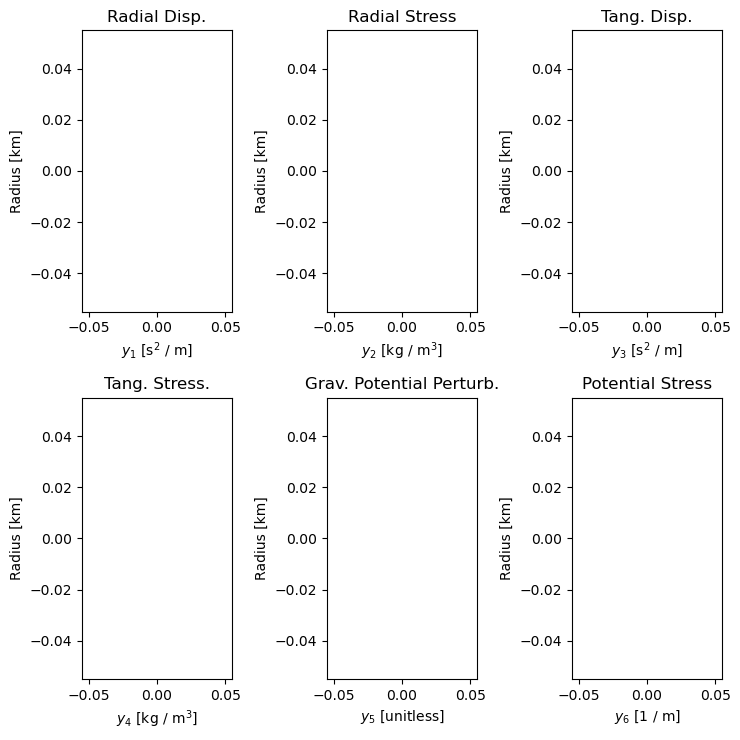

In [4]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
frequency = 0.1
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)

density_array = 3500. * np.ones_like(radius_array)

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)

viscosity_array = 1.0e20 * np.ones_like(radius_array)

shear_array = 5.0e10 * np.ones_like(radius_array)

result = np.empty((6, N), dtype=np.complex128, order='C')

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (False,)
is_static_by_layer = (False,)
is_incompressible_by_layer = (False,)
indicies = (radius_array >= 0.,)
upper_radius_by_layer = (radius_array[-1],)

print('Start')
result, success = radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_modulus_array,
        complex_shear_modulus_array,
        frequency,
        planet_bulk_density,
        is_solid_by_layer,
        is_static_by_layer,
        is_incompressible_by_layer,
        upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = True,
        integration_method = 1,
        integration_rtol = 1.0e-4,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = True,
        max_num_steps = 500_000,
        expected_size = 250,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = True,
        verbose = False,
        raise_on_fail = False
        )
print(success)
_ = yplot(result, radius_array)


In [ ]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old

indicies = (radius_array>=0.,)

out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - out), radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 312ms, 311ms, 298ms
# 297ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 4.93ms, 4.9ms
# 2.57ms, 2.33ms
# 2.42ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False)

## Liquid-Solid

True


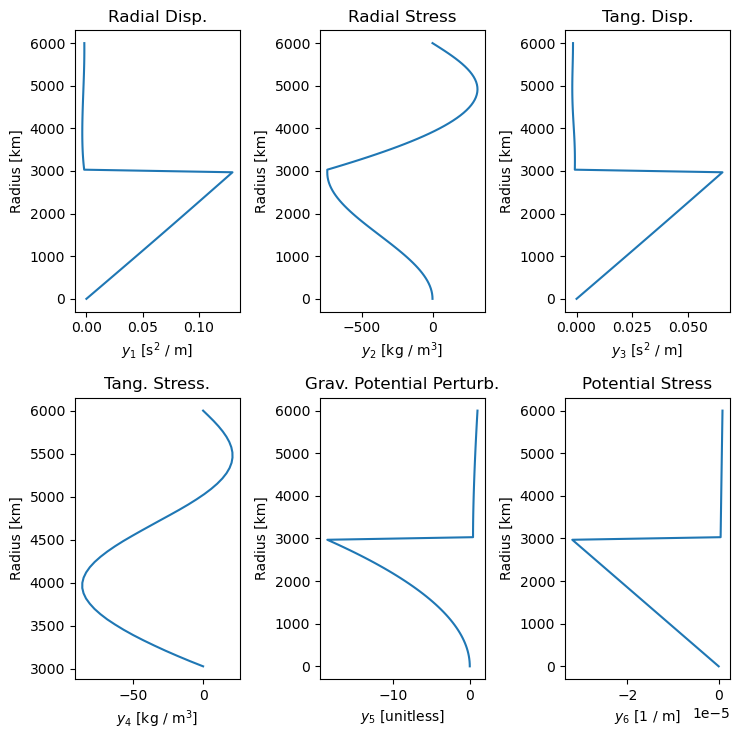

In [8]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
frequency = 0.01
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
CMB_radius = radius_array[-1] / 2.

density_array = 3500. * np.ones_like(radius_array)
density_array[radius_array <= CMB_radius] = 6000.

bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)
bulk_modulus_array[radius_array <= CMB_radius] = 5.0e11

viscosity_array = 1.0e20 * np.ones_like(radius_array)
viscosity_array[radius_array <= CMB_radius] = 1.0e15

shear_array = 5.0e10 * np.ones_like(radius_array)
shear_array[radius_array <= CMB_radius] = 0.

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (False, True,)
is_static_by_layer = (False, False,)
is_incompressible_by_layer = (False, False,)
indicies = (radius_array <= CMB_radius, radius_array > CMB_radius)
upper_radius_by_layer = (radius_array[-1]/2., radius_array[-1],)

result, success = radial_solver(
        radius_array,
        density_array,
        gravity_array,
        bulk_modulus_array,
        complex_shear_modulus_array,
        frequency,
        planet_bulk_density,
        is_solid_by_layer,
        is_static_by_layer,
        is_incompressible_by_layer,
        upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = True,
        integration_method = 1,
        integration_rtol = 1.0e-6,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = True,
        max_num_steps = 5_000_000,
        expected_size = 250,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False
        )

print(success)
_ = yplot(result, radius_array)


In [9]:
from TidalPy.radial_solver.numerical import radial_solver as radial_solver_old


out_old = radial_solver_old(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-12,integration_atol = 1.0e-12,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - result), radius_array)


KeyboardInterrupt



In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 144ms, 142ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 1.31ms, 1.31ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

## Solid-Liquid-Solid

In [ ]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
# frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
ICB_radius = radius_array[-1] * (1/3)
CMB_radius = radius_array[-1] * (2/3)

IC_index = radius_array <= ICB_radius
OC_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
mantle_index = radius_array > CMB_radius

density_array = np.empty_like(radius_array)
density_array[IC_index] = 11000.
density_array[OC_index] = 9000.
density_array[mantle_index] = 3950.

bulk_modulus_array = np.empty_like(radius_array)
bulk_modulus_array[IC_index] = 200.e9
bulk_modulus_array[OC_index] = 50.e9
bulk_modulus_array[mantle_index] = 100.e9

viscosity_array = np.empty_like(radius_array)
viscosity_array[IC_index] = 1.0e24
viscosity_array[OC_index] = 1000.
viscosity_array[mantle_index] = 1.0e18

shear_array = np.empty_like(radius_array)
shear_array[IC_index] = 100.0e9
shear_array[OC_index] = 0.
shear_array[mantle_index] = 50.0e9

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = np.sum(mass_array) / np.sum(volume_array)
is_solid_by_layer = (True, False, True)
is_static_by_layer = (False, True, False)
is_incompressible_by_layer = (False, False, False)

indicies = (IC_index, OC_index, mantle_index)
upper_radius_by_layer = (ICB_radius, CMB_radius, radius_array[-1],)

out = radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

#_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
_ = yplot(out, radius_array)

In [ ]:
out_old = radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

_ = yplot((out_old - out), radius_array)

In [ ]:
for i in range(6):
    print(f'{i}: np.asarray(\n    {list(out_old[i])}\n    dtype=np.complex128, order="C"),\n')

In [ ]:
# OLD (Not using NonDim):
# 356ms, 353ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

In [ ]:
# NEW (Not using NonDim):
# 2.23ms, 2.28ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-4,integration_atol = 1.0e-12,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)